<a href="https://colab.research.google.com/github/mjkleiman/streamlineAD/blob/master/KleimanPhD_Chp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 2: Electronic Health Records

In this chapter, I perform the majority of the predictive and feature analyses for examining and detecting Alzheimer's disease and/or its precursor stage mild cognitive impairment from Electronic Health Records.

Data is obtained from the Alzheimer's Disease Neuroimaging Initiative (ADNI) as well as real-world clinic data from the Comprehensive Center for Brain Health at Florida Atlantic Unviersity (Clinic)

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf

from google.colab import drive #Because I used Google Colab
drive.mount('/content/gdrive') # Mounting my google drive
dir='/content/gdrive/My Drive/Dissertation/' # My project folder

device_name = tf.test.gpu_device_name() # Make sure the GPU is running on Colab
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# !pip install rfpimp # Colab requires installation
# !pip install eli5 

'''Load datafiles'''
df_adni = pd.read_csv(f'{dir}/Data/imp_adni_all.csv') #Load imputed ADNI data
df_adni['Impaired'] = df_adni['DX'].replace({0:0,1:1,2:1})
df_adni = df_adni.loc[df_adni['VISCODE']==1]

df_clinic = pd.read_csv(f'{dir}/Data/data_Clinic.csv')
df_clinic['Impaired'] = df_clinic['diagnosis'].replace({1:0,2:1,3:1})
df_clinic['diagnosis'].replace({1:0,2:1,3:2}, inplace=True)

In [0]:
print('ADNI:\n',df_adni['DX'].value_counts())
print('\nCinic:\n',df_clinic['diagnosis'].value_counts())

ADNI:
 1.0    520
0.0    384
2.0    188
Name: DX, dtype: int64

Cinic:
 2    134
1     54
0     11
Name: diagnosis, dtype: int64


Here, we define two functions that are used to quickly and uniformly analyze 
each section and subsection of our data.

Typically in data science, only some of the following analyses would actually
be ran -- a tree-based method (i.e. random forest), a linear method (in this
case, logistic regression, due to our problem being a classification) and either
an SVM when the problem can be linearly separable, a K-nearest neighbors approach
when it is expected that the data may be non-linear, or a multilayer perceptron if a large amount of non-linear interactions are expected.

In this case, we run all of the above to ensure that the best model is identified at a glance. Further tuning of hyperparameters occur later, especially when investigating feature importances.

Pandas dataframes are used because they are simple, enable SQL-like queries and joins/merges/splits, work well with most other libraries (including scikit-learn which is used extensively in this project) and also because Pandas is awesome

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold, train_test_split as split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, cohen_kappa_score, f1_score
import xgboost
import eli5
from eli5.sklearn import PermutationImportance
import seaborn as sns
import matplotlib.pyplot as plt
import rfpimp

%matplotlib inline
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(15, 10)})


def ehr_analyses(X, y, k=5, random_state=0):
  '''Runs a series of boilerplate analyses on data using stratified k-fold CV (default=5)
  Output is a dataframe with mean scores of analyses. Arrays of cross validation
  can be called using scores_'analysis abbreviation' i.e. "scores_rf"
  '''
  df = pd.DataFrame(columns=['analysis','mean accuracy','AUC'])
  cv = StratifiedKFold(n_splits=k)
  
  #Random Forest
  rf = RandomForestClassifier(n_estimators=100, max_features=.5, random_state=random_state)

  y_pred = cross_val_predict(rf, X, y.values.ravel(), cv=cv)
  print('~~Random Forest~~')
  print(confusion_matrix(y, y_pred))
  print('Accuracy: \t', accuracy_score(y, y_pred))
  print('AUC: \t\t', roc_auc_score(y, y_pred))
  print('Kappa: \t\t', cohen_kappa_score(y, y_pred))
  print('F1 score: \t', f1_score(y, y_pred))
  print('\n')
  df = df.append({'analysis':'Random Forest','mean accuracy':accuracy_score(y, y_pred),'AUC':roc_auc_score(y, y_pred)}, ignore_index=True)
  
  #XGBoost
  xgb = xgboost.XGBClassifier(objective='binary:logistic', random_state=random_state)

  y_pred = cross_val_predict(xgb, X, y.values.ravel(), cv=cv)
  print('~~XGBoost~~')
  print(confusion_matrix(y, y_pred))
  print('Accuracy: \t', accuracy_score(y, y_pred))
  print('AUC: \t\t', roc_auc_score(y, y_pred))
  print('Kappa: \t\t', cohen_kappa_score(y, y_pred))
  print('F1 score: \t', f1_score(y, y_pred))
  print('\n')
  df = df.append({'analysis':'XGBoost','mean accuracy':accuracy_score(y, y_pred),'AUC':roc_auc_score(y, y_pred)}, ignore_index=True)
  
  #Logistic Regression
  lr = LogisticRegression(solver='liblinear', max_iter=10000, multi_class='auto', random_state=random_state)

  y_pred = cross_val_predict(lr, X, y.values.ravel(), cv=cv)
  print('~~Logistic Regression~~')
  print(confusion_matrix(y, y_pred))
  print('Accuracy: \t', accuracy_score(y, y_pred))
  print('AUC: \t\t', roc_auc_score(y, y_pred))
  print('Kappa: \t\t', cohen_kappa_score(y, y_pred))
  print('F1 score: \t', f1_score(y, y_pred))
  print('\n')
  df = df.append({'analysis':'LogRegression','mean accuracy':accuracy_score(y, y_pred), 'AUC':roc_auc_score(y, y_pred)}, ignore_index=True)
  
  #SVM
  svm = LinearSVC(penalty='l1', loss='squared_hinge', dual=False, max_iter=10000, random_state=random_state)

  y_pred = cross_val_predict(svm, X, y.values.ravel(), cv=cv)
  print('~~SVM~~')
  print(confusion_matrix(y, y_pred))
  print('Accuracy: \t', accuracy_score(y, y_pred))
  print('AUC: \t\t', roc_auc_score(y, y_pred))
  print('Kappa: \t\t', cohen_kappa_score(y, y_pred))
  print('F1 score: \t', f1_score(y, y_pred))
  print('\n')
  df = df.append({'analysis':'SVM','mean accuracy':accuracy_score(y, y_pred), 'AUC':roc_auc_score(y, y_pred)}, ignore_index=True)
 
  #MLP
  mlp = MLPClassifier(hidden_layer_sizes=(105,60,15), activation='relu', solver='sgd', alpha=.0001, learning_rate_init=.0005, max_iter=5000, random_state=random_state)

  y_pred = cross_val_predict(mlp, X, y.values.ravel(), cv=cv)
  print('~~MLP~~')
  print(confusion_matrix(y, y_pred))
  print('Accuracy: \t', accuracy_score(y, y_pred))
  print('AUC: \t\t', roc_auc_score(y, y_pred))
  print('Kappa: \t\t', cohen_kappa_score(y, y_pred))
  print('F1 score: \t', f1_score(y, y_pred))
  print('\n')
  df = df.append({'analysis':'MLP','mean accuracy':accuracy_score(y, y_pred), 'AUC':roc_auc_score(y, y_pred)}, ignore_index=True)
  
  return df

def ehr_analyses3(X, y, k=5, random_state=0):
  '''Runs a series of boilerplate analyses on data using stratified k-fold CV (default=5)
  Output is a dataframe with mean scores of analyses. Arrays of cross validation
  can be called using scores_'analysis abbreviation' i.e. "scores_rf"
  '''
  df = pd.DataFrame(columns=['analysis','mean accuracy'])
  cv = StratifiedKFold(n_splits=k)
  
  #Random Forest
  rf = RandomForestClassifier(n_estimators=100, max_features=.5, random_state=random_state)
  y_pred = cross_val_predict(rf, X, y.values.ravel(), cv=cv)
  print('~~Random Forest~~')
  print(confusion_matrix(y, y_pred))
  print('Accuracy: \t', accuracy_score(y, y_pred))
  print('Kappa: \t\t', cohen_kappa_score(y, y_pred))
  print('\n')
  df = df.append({'analysis':'Random Forest','mean accuracy':accuracy_score(y, y_pred)}, ignore_index=True)
  
  #XGBoost
  xgb = xgboost.XGBClassifier(objective='binary:logistic', random_state=random_state)

  y_pred = cross_val_predict(xgb, X, y.values.ravel(), cv=cv)
  print('~~XGBoost~~')
  print(confusion_matrix(y, y_pred))
  print('Accuracy: \t', accuracy_score(y, y_pred))
  print('Kappa: \t\t', cohen_kappa_score(y, y_pred))
  print('\n')
  df = df.append({'analysis':'Random Forest','mean accuracy':accuracy_score(y, y_pred)}, ignore_index=True)
  
  #Logistic Regression
  lr = LogisticRegression(solver='liblinear', max_iter=10000, multi_class='auto', random_state=random_state)

  y_pred = cross_val_predict(lr, X, y.values.ravel(), cv=cv)
  print('~~Logistic Regression~~')
  print(confusion_matrix(y, y_pred))
  print('Accuracy: \t', accuracy_score(y, y_pred))
  print('Kappa: \t\t', cohen_kappa_score(y, y_pred))
  print('\n')
  df = df.append({'analysis':'Random Forest','mean accuracy':accuracy_score(y, y_pred)}, ignore_index=True)
  
  #SVM
  svm = LinearSVC(penalty='l1', loss='squared_hinge', dual=False, max_iter=10000, random_state=random_state)

  y_pred = cross_val_predict(svm, X, y.values.ravel(), cv=cv)
  print('~~SVM~~')
  print(confusion_matrix(y, y_pred))
  print('Accuracy: \t', accuracy_score(y, y_pred))
  print('Kappa: \t\t', cohen_kappa_score(y, y_pred))
  print('\n')
  df = df.append({'analysis':'Random Forest','mean accuracy':accuracy_score(y, y_pred)}, ignore_index=True)
 
  #MLP
  mlp = MLPClassifier(hidden_layer_sizes=(105,60,15), activation='relu', solver='sgd', alpha=.0001, learning_rate_init=.0005, max_iter=5000, random_state=random_state)

  y_pred = cross_val_predict(mlp, X, y.values.ravel(), cv=cv)
  print('~~MLP~~')
  print(confusion_matrix(y, y_pred))
  print('Accuracy: \t', accuracy_score(y, y_pred))
  print('Kappa: \t\t', cohen_kappa_score(y, y_pred))
  print('\n')
  df = df.append({'analysis':'Random Forest','mean accuracy':accuracy_score(y, y_pred)}, ignore_index=True)
  
  return df

def ehr_feature(X, y, clf='rf', random_state=0, test_size=0.2):
  '''
  Plots and notes the feature importances using two consecutive methods:
    Permutation importance (in which a variable is replaced with noise) and
    Drop-column importance (in which a variable is dropped completely from the
    model)
    
  Classifier can be either random forest ('rf') or xgboost ('xgb')
  
  '''
  X_train, X_test, y_train, y_test = split(X, y.values.ravel(), test_size=test_size, random_state=random_state)
  
  # Select classifier ('rf' or 'xgb')
  if clf == 'rf':
    clf = RandomForestClassifier(n_estimators=100, max_features=.5, random_state=random_state)
  elif clf == 'xgb':
    clf = xgboost.XGBClassifier(objective='binary:logistic', random_state=random_state)
  else:
    print('Use either random forest (rf) or XGBoost (xgb)')
    raise 
  clf.fit(X_train, y_train) # Fit chosen classifier with training data
  
  perm = PermutationImportance(clf, cv=None, refit=False, n_iter=30).fit(X_test, y_test)
  df = pd.DataFrame({'Feature': X_test.columns, 'PermImportance': perm.feature_importances_}) \
            .sort_values('PermImportance', ascending = False) \
            .reset_index(drop = True)
  sns.barplot(x = 'PermImportance', y = 'Feature', data = df.head(20), orient = 'h', color = 'royalblue').set_title('Permutation feature importance', fontsize = 20)
  plt.show();plt.clf()
  
  drop = rfpimp.dropcol_importances(clf, X_train, y_train, X_valid=X_test, y_valid=y_test)
  drop.reset_index(inplace=True)
  drop.rename({'Importance':'DropImportance'}, axis=1, inplace=True)
  sns.barplot(x = 'DropImportance', y = 'Feature', data = drop.head(20), orient = 'h', color = 'firebrick').set_title('Drop column feature importance', fontsize = 20)
  
  df = df.merge(drop, on='Feature', how='left')
  return df

In [0]:
def paired_analyses(X_train, y_train, X_test, y_test, random_state=0):
  df = pd.DataFrame(columns=['analysis','mean accuracy'])
  
  #Random Forest
  rf = RandomForestClassifier(n_estimators=100, max_features=.5, random_state=random_state)
  rf.fit(X_train, y_train.values.ravel())
  
  y_pred = rf.predict(X_test)
  print('~~Random Forest~~')
  print(confusion_matrix(y_test, y_pred))
  print('Accuracy: \t', accuracy_score(y_test, y_pred))
  print('AUC: \t\t', roc_auc_score(y_test, y_pred))
  print('Kappa: \t\t', cohen_kappa_score(y_test, y_pred))
  print('F1 score: \t', f1_score(y_test, y_pred))
  print('\n')
  df = df.append({'analysis':'Random Forest','mean accuracy':accuracy_score(y_test, y_pred), 'AUC':roc_auc_score(y_test, y_pred)}, ignore_index=True)
  
  #XGBoost
  xgb = xgboost.XGBClassifier(objective='binary:logistic', random_state=random_state)
  xgb.fit(X_train, y_train.values.ravel())
  
  y_pred = xgb.predict(X_test)
  print('~~XGBoost~~')
  print(confusion_matrix(y_test, y_pred))
  print('Accuracy: \t', accuracy_score(y_test, y_pred))
  print('AUC: \t\t', roc_auc_score(y_test, y_pred))
  print('Kappa: \t\t', cohen_kappa_score(y_test, y_pred))
  print('F1 score: \t', f1_score(y_test, y_pred))
  print('\n')
  df = df.append({'analysis':'XGBoost','mean accuracy':accuracy_score(y_test, y_pred),'AUC':roc_auc_score(y_test, y_pred)}, ignore_index=True)
  
  #MLP
  mlp = MLPClassifier(hidden_layer_sizes=(105,60,15), activation='relu', solver='sgd', alpha=.0001, learning_rate_init=.0005, max_iter=5000, random_state=random_state)
  mlp.fit(X_train, y_train.values.ravel())

  y_pred = mlp.predict(X_test)
  print('~~MLP~~')
  print(confusion_matrix(y_test, y_pred))
  print('Accuracy: \t', accuracy_score(y_test, y_pred))
  print('AUC: \t\t', roc_auc_score(y_test, y_pred))
  print('Kappa: \t\t', cohen_kappa_score(y_test, y_pred))
  print('F1 score: \t', f1_score(y_test, y_pred))
  print('\n')
  df = df.append({'analysis':'MLP','mean accuracy':accuracy_score(y_test, y_pred),'AUC':roc_auc_score(y_test, y_pred)}, ignore_index=True)
  
  return df

def paired_feature(X_train, y_train, X_test, y_test, clf='rf', random_state=0):
  if clf == 'rf':
    clf = RandomForestClassifier(n_estimators=100, max_features=.5, random_state=random_state)
  elif clf == 'xgb':
    clf = xgboost.XGBClassifier(objective='binary:logistic', random_state=random_state)
  else:
    print('Use either random forest (rf) or XGBoost (xgb)')
    raise 
  clf.fit(X_train, y_train.values.ravel()) # Fit chosen classifier with training data
  
  perm = PermutationImportance(clf, cv=None, refit=False, n_iter=30).fit(X_test, y_test)
  df = pd.DataFrame({'Feature': X_test.columns, 'PermImportance': perm.feature_importances_}) \
            .sort_values('PermImportance', ascending = False) \
            .reset_index(drop = True)
  sns.barplot(x = 'PermImportance', y = 'Feature', data = df.head(20), orient = 'h', color = 'royalblue').set_title('Permutation feature importance', fontsize = 20)
  plt.show(); plt.clf()
  
  drop = rfpimp.dropcol_importances(clf, X_train, y_train.values.ravel(), X_valid=X_test, y_valid=y_test)
  drop.reset_index(inplace=True)
  drop.rename({'Importance':'DropImportance'}, axis=1, inplace=True)
  sns.barplot(x = 'DropImportance', y = 'Feature', data = drop.head(20), orient = 'h', color = 'firebrick').set_title('Drop column feature importance', fontsize = 20)
  plt.show(); plt.clf()
  
  df = df.merge(drop, on='Feature', how='left')
  return df


# ADNI Dataset

First, we investigate the ADNI dataset by itself, with all available features as well as with separated data types

## Predictive Analyses

### All Features

In [0]:
''' Features of ADNI dataset are selected. I chose to use this format of calling
features (instead of simply importing the dataset) to enable the reader to
easily identify which features are being used in each segment. 

A detailed description of each variable is noted in Appendix A.1 of the paper
'''

adni_X_cols = ['moca_visuo_exec', 'moca_clock',
       'moca_naming', 'moca_digits', 'moca_letters', 'moca_serial7',
       'moca_repeat', 'moca_fluency', 'moca_similarities', 'moca_recall',
       'moca_orient', 'ADAS_Q1', 'ADAS_Q2',
       'ADAS_Q3', 'ADAS_Q4', 'ADAS_Q5', 'ADAS_Q6', 'ADAS_Q7', 'ADAS_Q8',
       'ADAS_Q9', 'ADAS_Q10', 'ADAS_Q11', 'ADAS_Q12', 'ADAS_Q13',
       'faq1', 'faq2', 'faq3', 'faq4',
       'faq5', 'faq6', 'faq7', 'faq8', 'faq9', 'faq10', 'MMDATE',
       'MMYEAR', 'MMMONTH', 'MMDAY', 'MMSEASON', 'MMHOSPIT', 'MMFLOOR',
       'MMCITY', 'MMAREA', 'MMSTATE', 'MMBALL', 'MMFLAG', 'MMTREE', 'MMD',
       'MML', 'MMR', 'MMO', 'MMW', 'MMBALLDL', 'MMFLAGDL', 'MMTREEDL',
       'MMWATCH', 'MMPENCIL', 'MMREPEAT', 'MMHAND', 'MMFOLD', 'MMONFLR',
       'MMREAD', 'MMWRITE', 'MMDRAW', 'GDSATIS', 'GDDROP', 'GDEMPTY',
       'GDBORED', 'GDSPIRIT', 'GDAFRAID', 'GDHAPPY', 'GDHELP', 'GDHOME',
       'GDMEMORY', 'GDALIVE', 'GDWORTH', 'GDENERGY', 'GDHOPE', 'GDBETTER',
       'hach1', 'hach2', 'hach3', 'hach4', 'hach5', 'hach6', 'hach7',
       'hach8', 'PXGENAPP', 'PXHEADEY', 'PXNECK', 'PXCHEST', 'PXHEART',
       'PXABDOM', 'PXEXTREM', 'PXPERIPH', 'PXSKIN', 'PXMUSCUL',
       'CDR_orient', 'CDR_judge', 'CDR_comm',
       'CDR_home', 'CDR_care', 'CLOCKCIRC', 'CLOCKSYM',
       'CLOCKNUM', 'CLOCKHAND', 'CLOCKTIME', 'COPYCIRC', 'COPYSYM',
       'COPYNUM', 'COPYHAND', 'COPYTIME', 'AVTOT1', 'AVTOT2', 'AVTOT3',
       'AVTOT4', 'AVTOT5', 'AVTOT6', 'nbspan_forward', 'nbspan_backward',
       'CATANIMSC', 'CATVEGESC', 'tma_time', 'tmb_time', 'TRAAERRCOM',
       'TRAAERROM', 'TRABERRCOM', 'TRABERROM', 'LIMMTOTAL', 'LDELTOTAL',
       'AVDEL30MIN', 'AVDELTOT', 'AVDELERR2', 'vlt_recall', 'NPIA',
       'NPIASEV', 'NPIB', 'NPIBSEV', 'NPIC', 'NPICSEV', 'NPID', 'NPIDSEV',
       'NPIE', 'NPIESEV', 'NPIF', 'NPIFSEV', 'NPIG', 'NPIGSEV', 'NPIH',
       'NPIHSEV', 'NPII', 'NPIISEV', 'NPIJ', 'NPIJSEV', 'NPIK', 'NPIKSEV',
       'NPIL', 'NPILSEV', 'q_memory_pt', 'q_orient_pt',
       'q_judgmt_pt', 'q_outsideact_pt', 'q_homeact_pt', 'q_language_pt',
       'q_attention_pt', 'q_memory_cg', 'q_orient_cg',
       'q_judgmt_cg', 'q_outsideact_cg', 'q_homeact_cg', 'q_language_cg',
       'q_attention_cg', 'PTGENDER', 'PTHAND', 'PTMARRY',
       'PTEDUCAT', 'PTNOTRT', 'PTHOME', 'PTETHCAT', 'PTRACCAT', 'MHPSYCH',
       'MH2NEURL', 'MH3HEAD', 'MH4CARD', 'MH5RESP', 'MH6HEPAT', 'MH7DERM',
       'MH8MUSCL', 'MH9ENDO', 'MH10GAST', 'MH11HEMA', 'MH12RENA',
       'MH13ALLE', 'MH14ALCH', 'MH15DRUG', 'MH16SMOK', 'MH17MALI',
       'MH18SURG', 'MH19OTHR', 'FAMHISTAD', 'FAMHISTDEM']

'''The individual components of the ECOG (below) have been removed in favor
of consolidation into categories that resemble the QDRS

Removed = ['CDR_memory']
Removed = ['MEM1_pt', 'MEM2_pt', 'MEM3_pt', 'MEM4_pt',
       'MEM5_pt', 'MEM6_pt', 'MEM7_pt', 'MEM8_pt', 'LANG1_pt', 'LANG2_pt',
       'LANG3_pt', 'LANG4_pt', 'LANG5_pt', 'LANG6_pt', 'LANG7_pt',
       'LANG8_pt', 'LANG9_pt', 'VISSPAT1_pt', 'VISSPAT2_pt',
       'VISSPAT3_pt', 'VISSPAT4_pt', 'VISSPAT5_pt', 'VISSPAT6_pt',
       'VISSPAT7_pt', 'VISSPAT8_pt', 'PLAN1_pt', 'PLAN2_pt', 'PLAN3_pt',
       'PLAN4_pt', 'PLAN5_pt', 'ORGAN1_pt', 'ORGAN2_pt', 'ORGAN3_pt',
       'ORGAN4_pt', 'ORGAN5_pt', 'ORGAN6_pt', 'DIVATT1_pt', 'DIVATT2_pt',
       'DIVATT3_pt', 'DIVATT4_pt', 'MEM1_cg', 'MEM2_cg', 'MEM3_cg',
       'MEM4_cg', 'MEM5_cg', 'MEM6_cg', 'MEM7_cg', 'MEM8_cg', 'LANG1_cg',
       'LANG2_cg', 'LANG3_cg', 'LANG4_cg', 'LANG5_cg', 'LANG6_cg',
       'LANG7_cg', 'LANG8_cg', 'LANG9_cg', 'VISSPAT1_cg', 'VISSPAT2_cg',
       'VISSPAT3_cg', 'VISSPAT4_cg', 'VISSPAT5_cg', 'VISSPAT6_cg',
       'VISSPAT7_cg', 'VISSPAT8_cg', 'PLAN1_cg', 'PLAN2_cg', 'PLAN3_cg',
       'PLAN4_cg', 'PLAN5_cg', 'ORGAN1_cg', 'ORGAN2_cg', 'ORGAN3_cg',
       'ORGAN4_cg', 'ORGAN5_cg', 'ORGAN6_cg', 'DIVATT1_cg', 'DIVATT2_cg',
       'DIVATT3_cg', 'DIVATT4_cg']
'''

df_adni_X = df_adni.loc[:,adni_X_cols]
df_adni_y2 = df_adni.loc[:,['Impaired']]
df_adni_y3 = df_adni.loc[:,['DX']]


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_adni_X_scaled = scaler.fit_transform(df_adni[adni_X_cols])
df_adni_X_scaled = pd.DataFrame(df_adni_X_scaled, columns=df_adni_X.columns)
df_adni_X_scale = df_adni_X_scaled

#### Binary (Impaired/Not Impaired)



In [0]:
ehr_all_2 = ehr_analyses(df_adni_X_scale, df_adni_y2)

~~Random Forest~~
[[326  58]
 [ 37 671]]
Accuracy: 	 0.913003663003663
AUC: 		 0.8983492231638418
Kappa: 		 0.8067940552016986
F1 score: 	 0.9338900487125956


~~XGBoost~~
[[333  51]
 [ 50 658]]
Accuracy: 	 0.9075091575091575
AUC: 		 0.8982830155367232
Kappa: 		 0.7970409627912112
F1 score: 	 0.9287226534932957


~~Logistic Regression~~
[[319  65]
 [ 71 637]]
Accuracy: 	 0.8754578754578755
AUC: 		 0.8652233403954802
Kappa: 		 0.7278444825614637
F1 score: 	 0.9035460992907802


~~SVM~~
[[323  61]
 [ 71 637]]
Accuracy: 	 0.8791208791208791
AUC: 		 0.8704316737288136
Kappa: 		 0.7364749243122285
F1 score: 	 0.9061166429587483


~~MLP~~
[[318  66]
 [ 77 631]]
Accuracy: 	 0.8690476190476191
AUC: 		 0.8596839689265536
Kappa: 		 0.714683505448486
F1 score: 	 0.898220640569395




In [0]:
ehr_all_2.to_csv(f'{dir}/Output/ehr_all_2_nocdrmem.csv', index=False)

#### Ternary (AD/MCI/NL)

In [0]:
ehr_all_3 = ehr_analyses3(df_adni_X_scale, df_adni_y3)

~~Random Forest~~
[[329  55   0]
 [ 39 444  37]
 [  0  41 147]]
Accuracy: 	 0.8424908424908425
Kappa: 		 0.744721104708057


~~XGBoost~~
[[337  47   0]
 [ 57 424  39]
 [  2  38 148]]
Accuracy: 	 0.8324175824175825
Kappa: 		 0.7301570154638897


~~Logistic Regression~~
[[328  56   0]
 [ 68 421  31]
 [  1  48 139]]
Accuracy: 	 0.8131868131868132
Kappa: 		 0.6969373761999085


~~SVM~~
[[323  61   0]
 [ 68 413  39]
 [  2  47 139]]
Accuracy: 	 0.8012820512820513
Kappa: 		 0.6785481735506695


~~MLP~~
[[320  64   0]
 [ 70 413  37]
 [  0  47 141]]
Accuracy: 	 0.8003663003663004
Kappa: 		 0.676887996090993




In [0]:
ehr_all_3.to_csv(f'{dir}/Output/ehr_all_3_nocdrmem.csv', index=False)

### Cognitive Exam Features

In [0]:
adni_X_cols = ['moca_visuo_exec', 'moca_clock', 'moca_naming', 'moca_digits',
       'moca_letters', 'moca_serial7', 'moca_repeat', 'moca_fluency',
       'moca_similarities', 'moca_recall', 'moca_orient', 'ADAS_Q1',
       'ADAS_Q2', 'ADAS_Q3', 'ADAS_Q4', 'ADAS_Q5', 'ADAS_Q6', 'ADAS_Q7',
       'ADAS_Q8', 'ADAS_Q9', 'ADAS_Q10', 'ADAS_Q11', 'ADAS_Q12',
       'ADAS_Q13', 'MMDATE', 'MMYEAR', 'MMMONTH', 'MMDAY', 'MMSEASON',
       'MMHOSPIT', 'MMFLOOR', 'MMCITY', 'MMAREA', 'MMSTATE', 'MMBALL',
       'MMFLAG', 'MMTREE', 'MMD', 'MML', 'MMR', 'MMO', 'MMW', 'MMBALLDL',
       'MMFLAGDL', 'MMTREEDL', 'MMWATCH', 'MMPENCIL', 'MMREPEAT',
       'MMHAND', 'MMFOLD', 'MMONFLR', 'MMREAD', 'MMWRITE', 'MMDRAW',
       'CDR_orient', 'CDR_judge', 'CDR_comm', 'CDR_home',
       'CDR_care', 'CLOCKCIRC', 'CLOCKSYM', 'CLOCKNUM',
       'CLOCKHAND', 'CLOCKTIME', 'COPYCIRC', 'COPYSYM', 'COPYNUM',
       'COPYHAND', 'COPYTIME', 'AVTOT1', 'AVTOT2', 'AVTOT3', 'AVTOT4',
       'AVTOT5', 'AVTOT6', 'nbspan_forward', 'nbspan_backward',
       'CATANIMSC', 'CATVEGESC', 'tma_time', 'tmb_time', 'TRAAERRCOM',
       'TRAAERROM', 'TRABERRCOM', 'TRABERROM', 'LIMMTOTAL', 'LDELTOTAL',
       'AVDEL30MIN', 'AVDELTOT', 'AVDELERR2', 'vlt_recall']
df_adni_X = df_adni.loc[:,adni_X_cols]
df_adni_y2 = df_adni.loc[:,['Impaired']]
df_adni_y3 = df_adni.loc[:,['DX']]
df_adni_X_scale = df_adni_X_scaled.loc[:,adni_X_cols]

#### Binary (Impaired/Not)

In [0]:
ehr_cog_2 = ehr_analyses(df_adni_X_scale, df_adni_y2)

~~Random Forest~~
[[315  69]
 [ 51 657]]
Accuracy: 	 0.8901098901098901
AUC: 		 0.8741393008474576
Kappa: 		 0.756391380002677
F1 score: 	 0.9163179916317992


~~XGBoost~~
[[328  56]
 [ 55 653]]
Accuracy: 	 0.8983516483516484
AUC: 		 0.8882415254237288
Kappa: 		 0.7769460086121232
F1 score: 	 0.9216654904728299


~~Logistic Regression~~
[[325  59]
 [ 65 643]]
Accuracy: 	 0.8864468864468864
AUC: 		 0.8772731285310734
Kappa: 		 0.7518582046883934
F1 score: 	 0.9120567375886526


~~SVM~~
[[327  57]
 [ 67 641]]
Accuracy: 	 0.8864468864468864
AUC: 		 0.878464865819209
Kappa: 		 0.7524461410205783
F1 score: 	 0.9118065433854907


~~MLP~~
[[322  62]
 [ 67 641]]
Accuracy: 	 0.8818681318681318
AUC: 		 0.8719544491525423
Kappa: 		 0.741699122054261
F1 score: 	 0.9085754783841248




In [0]:
ehr_cog_2.to_csv(f'{dir}/Output/ehr_cog_2_nocdrmem.csv', index=False)

#### Ternary (AD/MCI/NL)

In [0]:
ehr_cog_3 = ehr_analyses3(df_adni_X_scale, df_adni_y3)

~~Random Forest~~
[[315  69   0]
 [ 57 414  49]
 [  2  47 139]]
Accuracy: 	 0.7948717948717948
Kappa: 		 0.6685097248422559


~~XGBoost~~
[[333  51   0]
 [ 70 393  57]
 [  4  38 146]]
Accuracy: 	 0.7985347985347986
Kappa: 		 0.678553651996596


~~Logistic Regression~~
[[325  59   0]
 [ 65 420  35]
 [  4  51 133]]
Accuracy: 	 0.8040293040293041
Kappa: 		 0.6816170379735798


~~SVM~~
[[325  58   1]
 [ 62 412  46]
 [  4  53 131]]
Accuracy: 	 0.7948717948717948
Kappa: 		 0.6680562793121417


~~MLP~~
[[321  63   0]
 [ 59 426  35]
 [  0  49 139]]
Accuracy: 	 0.8113553113553114
Kappa: 		 0.69355594546584




In [0]:
ehr_cog_3.to_csv(f'{dir}/Output/ehr_cog_3_nocdrmem.csv', index=False)

### Questionnaire Features (QDRS-like)

In [0]:
adni_X_cols = ['q_memory_pt', 'q_orient_pt',
       'q_judgmt_pt', 'q_outsideact_pt', 'q_homeact_pt', 'q_language_pt',
       'q_attention_pt', 'q_memory_cg', 'q_orient_cg',
       'q_judgmt_cg', 'q_outsideact_cg', 'q_homeact_cg', 'q_language_cg',
       'q_attention_cg']
df_adni_X = df_adni.loc[:,adni_X_cols]
df_adni_X_scale = df_adni_X_scaled.loc[:,adni_X_cols]

#### Binary (Impaired/Not)

In [0]:
ehr_ques_2 = ehr_analyses(df_adni_X_scale, df_adni_y2)

~~Random Forest~~
[[270 114]
 [125 583]]
Accuracy: 	 0.7811355311355311
AUC: 		 0.763285663841808
Kappa: 		 0.523142362253064
F1 score: 	 0.8298932384341636


~~XGBoost~~
[[280 104]
 [105 603]]
Accuracy: 	 0.8086080586080586
AUC: 		 0.7904307909604521
Kappa: 		 0.5805156708352632
F1 score: 	 0.8522968197879858


~~Logistic Regression~~
[[281 103]
 [107 601]]
Accuracy: 	 0.8076923076923077
AUC: 		 0.7903204449152542
Kappa: 		 0.5792602377807133
F1 score: 	 0.8512747875354109


~~SVM~~
[[290  94]
 [117 591]]
Accuracy: 	 0.8067765567765568
AUC: 		 0.7949770480225989
Kappa: 		 0.5819780985348224
F1 score: 	 0.8485283560660445


~~MLP~~
[[275 109]
 [ 97 611]]
Accuracy: 	 0.8113553113553114
AUC: 		 0.7895700918079095
Kappa: 		 0.5833111051836045
F1 score: 	 0.8557422969187675




In [0]:
ehr_ques_2.to_csv(f'{dir}/Output/ehr_ques_2.csv', index=False)

#### Ternary (AD/MCI/NL)

In [0]:
ehr_ques_3 = ehr_analyses3(df_adni_X_scale, df_adni_y3)

~~Random Forest~~
[[275 106   3]
 [116 345  59]
 [  2  84 102]]
Accuracy: 	 0.6611721611721612
Kappa: 		 0.44842461639272657


~~XGBoost~~
[[280 100   4]
 [ 98 368  54]
 [  2  71 115]]
Accuracy: 	 0.6987179487179487
Kappa: 		 0.510360618202633


~~Logistic Regression~~
[[290  91   3]
 [110 362  48]
 [  6  73 109]]
Accuracy: 	 0.6968864468864469
Kappa: 		 0.5068598559266535


~~SVM~~
[[290  90   4]
 [120 352  48]
 [  6  77 105]]
Accuracy: 	 0.6840659340659341
Kappa: 		 0.4862570978176085


~~MLP~~
[[288  93   3]
 [112 357  51]
 [  2  66 120]]
Accuracy: 	 0.7005494505494505
Kappa: 		 0.5155318941096024




In [0]:
ehr_ques_3.to_csv(f'{dir}/Output/ehr_ques_3.csv', index=False)

### Functioning/Lifestyle Features

In [0]:
adni_X_cols = ['faq1', 'faq2', 'faq3', 'faq4',
       'faq5', 'faq6', 'faq7', 'faq8', 'faq9', 'faq10']
df_adni_X = df_adni.loc[:,adni_X_cols]
df_adni_y2 = df_adni.loc[:,['Impaired']]
df_adni_y3 = df_adni.loc[:,['DX']]
df_adni_X_scale = df_adni_X_scaled.loc[:,adni_X_cols]

#### Binary (Impaired/Not)

In [0]:
ehr_func_2 = ehr_analyses(df_adni_X_scale, df_adni_y2)

~~Random Forest~~
[[313  71]
 [216 492]]
Accuracy: 	 0.7373197758226968
AUC: 		 0.7550097104519773
Kappa: 		 0.46945781786418017
F1 score: 	 0.7741935483870968


~~XGBoost~~
[[323  61]
 [213 495]]
Accuracy: 	 0.7490842490842491
AUC: 		 0.7701491878531075
Kappa: 		 0.4954265824834062
F1 score: 	 0.7832278481012659


~~Logistic Regression~~
[[312  72]
 [207 501]]
Accuracy: 	 0.7445054945054945
AUC: 		 0.760063559322034
Kappa: 		 0.48140204669403763
F1 score: 	 0.7822014051522248


~~SVM~~
[[317  67]
 [211 497]]
Accuracy: 	 0.7454212454212454
AUC: 		 0.7637491172316384
Kappa: 		 0.4858130081300812
F1 score: 	 0.7814465408805031


~~MLP~~
[[304  80]
 [196 512]]
Accuracy: 	 0.7472527472527473
AUC: 		 0.7574152542372881
Kappa: 		 0.48154570225414917
F1 score: 	 0.7876923076923078




In [0]:
ehr_func_2.to_csv(f'{dir}/Output/ehr_func_2.csv', index=False)

#### Ternary (AD/MCI/NL)

In [0]:
ehr_func_3 = ehr_analyses3(df_adni_X_scale, df_adni_y3)

~~Random Forest~~
[[326  54   4]
 [213 253  54]
 [ 15  74  99]]
Accuracy: 	 0.6208791208791209
Kappa: 		 0.3988926886604298


~~XGBoost~~
[[325  57   2]
 [197 287  36]
 [ 16  74  98]]
Accuracy: 	 0.6501831501831502
Kappa: 		 0.4385256493086962


~~Logistic Regression~~
[[321  62   1]
 [204 269  47]
 [ 15  74  99]]
Accuracy: 	 0.6309523809523809
Kappa: 		 0.41077138128825985


~~SVM~~
[[329  52   3]
 [212 255  53]
 [ 18  67 103]]
Accuracy: 	 0.6291208791208791
Kappa: 		 0.41300920051603585


~~MLP~~
[[319  63   2]
 [193 274  53]
 [ 14  63 111]]
Accuracy: 	 0.6209387554881682
Kappa: 		 0.4360284956713415




In [0]:
ehr_func_3.to_csv(f'{dir}/Output/ehr_func_3.csv', index=False)

### All Questionnaires

In [0]:
adni_X_cols = ['q_memory_pt', 'q_orient_pt',
       'q_judgmt_pt', 'q_outsideact_pt', 'q_homeact_pt', 'q_language_pt',
       'q_attention_pt', 'q_memory_cg', 'q_orient_cg',
       'q_judgmt_cg', 'q_outsideact_cg', 'q_homeact_cg', 'q_language_cg',
       'q_attention_cg', 'faq1', 'faq2', 'faq3', 'faq4',
       'faq5', 'faq6', 'faq7', 'faq8', 'faq9', 'faq10']
df_adni_X = df_adni.loc[:,adni_X_cols]
df_adni_X_scale = df_adni_X_scaled.loc[:,adni_X_cols]

#### Binary (Impaired/Not)

In [0]:
ehr_allques_2 = ehr_analyses(df_adni_X_scale, df_adni_y2)

~~Random Forest~~
[[278 106]
 [114 594]]
Accuracy: 	 0.7985347985347986
AUC: 		 0.7814706920903953
Kappa: 		 0.5602706027060271
F1 score: 	 0.8437499999999999


~~XGBoost~~
[[291  93]
 [115 593]]
Accuracy: 	 0.8095238095238095
AUC: 		 0.7976915607344632
Kappa: 		 0.5876791704788045
F1 score: 	 0.8507890961262553


~~Logistic Regression~~
[[298  86]
 [112 596]]
Accuracy: 	 0.8186813186813187
AUC: 		 0.8089247881355932
Kappa: 		 0.6084235232755248
F1 score: 	 0.8575539568345324


~~SVM~~
[[303  81]
 [122 586]]
Accuracy: 	 0.8141025641025641
AUC: 		 0.8083730579096045
Kappa: 		 0.602037958594541
F1 score: 	 0.8523636363636362


~~MLP~~
[[291  93]
 [108 600]]
Accuracy: 	 0.8159340659340659
AUC: 		 0.802635063559322
Kappa: 		 0.5999081304547542
F1 score: 	 0.8565310492505354




In [0]:
ehr_allques_2.to_csv(f'{dir}/Output/ehr_allques_2.csv', index=False)

#### Ternary (AD/MCI/NL)

In [0]:
ehr_allques_3 = ehr_analyses3(df_adni_X_scale, df_adni_y3)

~~Random Forest~~
[[281 100   3]
 [104 368  48]
 [  2  73 113]]
Accuracy: 	 0.6978021978021978
Kappa: 		 0.5075057673594787


~~XGBoost~~
[[287  93   4]
 [103 371  46]
 [  3  79 106]]
Accuracy: 	 0.6996336996336996
Kappa: 		 0.5092565190227221


~~Logistic Regression~~
[[299  84   1]
 [113 365  42]
 [  3  77 108]]
Accuracy: 	 0.706959706959707
Kappa: 		 0.5220980421118278


~~SVM~~
[[295  88   1]
 [130 344  46]
 [  5  71 112]]
Accuracy: 	 0.6877289377289377
Kappa: 		 0.4939855304854517


~~MLP~~
[[297  86   1]
 [111 361  48]
 [  3  70 115]]
Accuracy: 	 0.7078754578754579
Kappa: 		 0.5260365077119004




In [0]:
ehr_allques_3.to_csv(f'{dir}/Output/ehr_allques_3.csv', index=False)

### Mental Exam Features

In [0]:
adni_X_cols = ['GDSATIS', 'GDDROP', 'GDEMPTY',
       'GDBORED', 'GDSPIRIT', 'GDAFRAID', 'GDHAPPY', 'GDHELP', 'GDHOME',
       'GDMEMORY', 'GDALIVE', 'GDWORTH', 'GDENERGY', 'GDHOPE', 'GDBETTER',
       'hach1', 'hach2', 'hach3', 'hach4', 'hach5', 'hach6', 'hach7',
       'hach8', 'NPIA',
       'NPIASEV', 'NPIB', 'NPIBSEV', 'NPIC', 'NPICSEV', 'NPID', 'NPIDSEV',
       'NPIE', 'NPIESEV', 'NPIF', 'NPIFSEV', 'NPIG', 'NPIGSEV', 'NPIH',
       'NPIHSEV', 'NPII', 'NPIISEV', 'NPIJ', 'NPIJSEV', 'NPIK', 'NPIKSEV',
       'NPIL', 'NPILSEV']
df_adni_X = df_adni.loc[:,adni_X_cols]
df_adni_y2 = df_adni.loc[:,['Impaired']]
df_adni_y3 = df_adni.loc[:,['DX']]
df_adni_X_scale = df_adni_X_scaled.loc[:,adni_X_cols]

#### Binary (Impaired/Not)

In [0]:
ehr_mental_2 = ehr_analyses(df_adni_X_scale, df_adni_y2)

~~Random Forest~~
[[258 126]
 [159 549]]
Accuracy: 	 0.7389526307589932
AUC: 		 0.7236493644067796
Kappa: 		 0.4386728134536718
F1 score: 	 0.7939262472885034


~~XGBoost~~
[[265 119]
 [140 568]]
Accuracy: 	 0.7628205128205128
AUC: 		 0.7461820268361582
Kappa: 		 0.48627912552583974
F1 score: 	 0.814336917562724


~~Logistic Regression~~
[[272 112]
 [144 564]]
Accuracy: 	 0.7655677655677655
AUC: 		 0.7524717514124294
Kappa: 		 0.49549549549549554
F1 score: 	 0.815028901734104


~~SVM~~
[[280 104]
 [153 555]]
Accuracy: 	 0.7646520146520146
AUC: 		 0.7565324858757062
Kappa: 		 0.49850970301275865
F1 score: 	 0.8119970738844183


~~MLP~~
[[264 120]
 [137 571]]
Accuracy: 	 0.7646520146520146
AUC: 		 0.7469985875706215
Kappa: 		 0.48904328067990643
F1 score: 	 0.8162973552537527




In [0]:
ehr_mental_2.to_csv(f'{dir}/Output/ehr_mental_2.csv', index=False)

#### Ternary (AD/MCI/NL)

In [0]:
ehr_mental_3 = ehr_analyses3(df_adni_X_scale, df_adni_y3)

~~Random Forest~~
[[263 113   8]
 [137 316  67]
 [ 30 121  37]]
Accuracy: 	 0.5641025641025641
Kappa: 		 0.27835532453685197


~~XGBoost~~
[[280 102   2]
 [132 361  27]
 [ 31 133  24]]
Accuracy: 	 0.6089743589743589
Kappa: 		 0.33622029757939154


~~Logistic Regression~~
[[282 100   2]
 [143 355  22]
 [ 34 127  27]]
Accuracy: 	 0.608058608058608
Kappa: 		 0.3360947754197563


~~SVM~~
[[289  94   1]
 [156 338  26]
 [ 39 119  30]]
Accuracy: 	 0.6016483516483516
Kappa: 		 0.33036545000366524


~~MLP~~
[[270 110   4]
 [133 359  28]
 [ 33 126  29]]
Accuracy: 	 0.5639939482707262
Kappa: 		 0.32697125134200167




In [0]:
ehr_mental_3.to_csv(f'{dir}/Output/ehr_mental_3.csv', index=False)

### Physical Exam Features

In [0]:
adni_X_cols = ['PXGENAPP', 'PXHEADEY', 'PXNECK', 'PXCHEST', 'PXHEART',
       'PXABDOM', 'PXEXTREM', 'PXPERIPH', 'PXSKIN', 'PXMUSCUL']
df_adni_X = df_adni.loc[:,adni_X_cols]
df_adni_y2 = df_adni.loc[:,['Impaired']]
df_adni_y3 = df_adni.loc[:,['DX']]
df_adni_X_scale = df_adni_X_scaled.loc[:,adni_X_cols]

#### Binary (Impaired/Not)

In [0]:
ehr_phys_2 = ehr_analyses(df_adni_X_scale, df_adni_y2)

~~Random Forest~~
[[ 22 362]
 [ 48 660]]
Accuracy: 	 0.6245496386394845
AUC: 		 0.49474752824858753
Kappa: 		 -0.012922843025465758
F1 score: 	 0.7630057803468208


~~XGBoost~~
[[  4 380]
 [ 21 687]]
Accuracy: 	 0.6327838827838828
AUC: 		 0.490377824858757
Kappa: 		 -0.024481316151492294
F1 score: 	 0.7740845070422535


~~Logistic Regression~~
[[  0 384]
 [  8 700]]
Accuracy: 	 0.6410256410256411
AUC: 		 0.4943502824858757
Kappa: 		 -0.014562002275312791
F1 score: 	 0.78125


~~SVM~~
[[  2 382]
 [ 10 698]]
Accuracy: 	 0.6410256410256411
AUC: 		 0.4955420197740113
Kappa: 		 -0.011455143472836493
F1 score: 	 0.7807606263982103


~~MLP~~
[[  0 384]
 [  0 708]]
Accuracy: 	 0.6483516483516484
AUC: 		 0.5
Kappa: 		 0.0
F1 score: 	 0.7866666666666667




In [0]:
ehr_phys_2.to_csv(f'{dir}/Output/ehr_phys_2.csv', index=False)

#### Ternary (AD/MCI/NL)

In [0]:
ehr_phys_3 = ehr_analyses3(df_adni_X_scale, df_adni_y3)

~~Random Forest~~
[[ 31 341  12]
 [ 47 450  23]
 [ 19 165   4]]
Accuracy: 	 0.4441391941391941
Kappa: 		 -0.018562796958651706


~~XGBoost~~
[[ 18 360   6]
 [ 24 484  12]
 [  9 177   2]]
Accuracy: 	 0.46153846153846156
Kappa: 		 -0.006104669382638761


~~Logistic Regression~~
[[  4 380   0]
 [ 14 506   0]
 [  5 183   0]]
Accuracy: 	 0.46703296703296704
Kappa: 		 -0.01241254508149714


~~SVM~~
[[  4 380   0]
 [ 13 507   0]
 [  4 184   0]]
Accuracy: 	 0.46794871794871795
Kappa: 		 -0.011111111111111072


~~MLP~~
[[  0 384   0]
 [  1 519   0]
 [  0 188   0]]
Accuracy: 	 0.4441239944270345
Kappa: 		 -0.0015301875920352703




In [0]:
ehr_phys_3.to_csv(f'{dir}/Output/ehr_phys_3.csv', index=False)

### Demographics Features

In [0]:
adni_X_cols = ['PTGENDER', 'PTHAND', 'PTMARRY',
       'PTEDUCAT', 'PTNOTRT', 'PTHOME', 'PTETHCAT', 'PTRACCAT', 'MHPSYCH',
       'MH2NEURL', 'MH3HEAD', 'MH4CARD', 'MH5RESP', 'MH6HEPAT', 'MH7DERM',
       'MH8MUSCL', 'MH9ENDO', 'MH10GAST', 'MH11HEMA', 'MH12RENA',
       'MH13ALLE', 'MH14ALCH', 'MH15DRUG', 'MH16SMOK', 'MH17MALI',
       'MH18SURG', 'MH19OTHR', 'FAMHISTAD', 'FAMHISTDEM']
df_adni_X = df_adni.loc[:,adni_X_cols]
df_adni_y2 = df_adni.loc[:,['Impaired']]
df_adni_y3 = df_adni.loc[:,['DX']]
df_adni_X_scale = df_adni_X_scaled.loc[:,adni_X_cols]

#### Binary (Impaired/Not)

In [0]:
ehr_demogs_2 = ehr_analyses(df_adni_X_scale, df_adni_y2)

~~Random Forest~~
[[ 94 290]
 [128 580]]
Accuracy: 	 0.6172143010617552
AUC: 		 0.5320003531073446
Kappa: 		 0.07083882944941122
F1 score: 	 0.7351077313054498


~~XGBoost~~
[[ 80 304]
 [ 97 611]]
Accuracy: 	 0.6327838827838828
AUC: 		 0.5356638418079096
Kappa: 		 0.08136344183470534
F1 score: 	 0.7529266789895256


~~Logistic Regression~~
[[ 91 293]
 [ 92 616]]
Accuracy: 	 0.6474358974358975
AUC: 		 0.5535178319209039
Kappa: 		 0.12159959884668425
F1 score: 	 0.761904761904762


~~SVM~~
[[ 92 292]
 [ 91 617]]
Accuracy: 	 0.6492673992673993
AUC: 		 0.5555261299435028
Kappa: 		 0.12616271781371446
F1 score: 	 0.7631416202844775


~~MLP~~
[[  0 384]
 [  0 708]]
Accuracy: 	 0.6483516483516484
AUC: 		 0.5
Kappa: 		 0.0
F1 score: 	 0.7866666666666667




In [0]:
ehr_demogs_2.to_csv(f'{dir}/Output/ehr_demogs_2.csv', index=False)

#### Ternary (AD/MCI/NL)

In [0]:
ehr_demogs_3 = ehr_analyses3(df_adni_X_scale, df_adni_y3)

~~Random Forest~~
[[136 232  16]
 [156 339  25]
 [ 36 133  19]]
Accuracy: 	 0.4523809523809524
Kappa: 		 0.05243545690936113


~~XGBoost~~
[[128 247   9]
 [140 356  24]
 [ 38 136  14]]
Accuracy: 	 0.45604395604395603
Kappa: 		 0.04868562310440505


~~Logistic Regression~~
[[152 230   2]
 [136 373  11]
 [ 40 138  10]]
Accuracy: 	 0.4899267399267399
Kappa: 		 0.10138461265712073


~~SVM~~
[[150 231   3]
 [147 362  11]
 [ 43 136   9]]
Accuracy: 	 0.47710622710622713
Kappa: 		 0.0810140014738393


~~MLP~~
[[  5 379   0]
 [ 11 509   0]
 [  6 182   0]]
Accuracy: 	 0.45239790216499703
Kappa: 		 -0.005672258196094404




In [0]:
ehr_demogs_3.to_csv(f'{dir}/Output/ehr_demogs_3.csv', index=False)

## Feature Importances

### All Features

In [0]:
adni_X_cols = ['moca_visuo_exec', 'moca_clock',
       'moca_naming', 'moca_digits', 'moca_letters', 'moca_serial7',
       'moca_repeat', 'moca_fluency', 'moca_similarities', 'moca_recall',
       'moca_orient', 'ADAS_Q1', 'ADAS_Q2',
       'ADAS_Q3', 'ADAS_Q4', 'ADAS_Q5', 'ADAS_Q6', 'ADAS_Q7', 'ADAS_Q8',
       'ADAS_Q9', 'ADAS_Q10', 'ADAS_Q11', 'ADAS_Q12', 'ADAS_Q13',
       'faq1', 'faq2', 'faq3', 'faq4',
       'faq5', 'faq6', 'faq7', 'faq8', 'faq9', 'faq10', 'MMDATE',
       'MMYEAR', 'MMMONTH', 'MMDAY', 'MMSEASON', 'MMHOSPIT', 'MMFLOOR',
       'MMCITY', 'MMAREA', 'MMSTATE', 'MMBALL', 'MMFLAG', 'MMTREE', 'MMD',
       'MML', 'MMR', 'MMO', 'MMW', 'MMBALLDL', 'MMFLAGDL', 'MMTREEDL',
       'MMWATCH', 'MMPENCIL', 'MMREPEAT', 'MMHAND', 'MMFOLD', 'MMONFLR',
       'MMREAD', 'MMWRITE', 'MMDRAW', 'GDSATIS', 'GDDROP', 'GDEMPTY',
       'GDBORED', 'GDSPIRIT', 'GDAFRAID', 'GDHAPPY', 'GDHELP', 'GDHOME',
       'GDMEMORY', 'GDALIVE', 'GDWORTH', 'GDENERGY', 'GDHOPE', 'GDBETTER',
       'hach1', 'hach2', 'hach3', 'hach4', 'hach5', 'hach6', 'hach7',
       'hach8', 'PXGENAPP', 'PXHEADEY', 'PXNECK', 'PXCHEST', 'PXHEART',
       'PXABDOM', 'PXEXTREM', 'PXPERIPH', 'PXSKIN', 'PXMUSCUL',
       'CDR_orient', 'CDR_judge', 'CDR_comm',
       'CDR_home', 'CDR_care', 'CLOCKCIRC', 'CLOCKSYM',
       'CLOCKNUM', 'CLOCKHAND', 'CLOCKTIME', 'COPYCIRC', 'COPYSYM',
       'COPYNUM', 'COPYHAND', 'COPYTIME', 'AVTOT1', 'AVTOT2', 'AVTOT3',
       'AVTOT4', 'AVTOT5', 'AVTOT6', 'nbspan_forward', 'nbspan_backward',
       'CATANIMSC', 'CATVEGESC', 'tma_time', 'tmb_time', 'TRAAERRCOM',
       'TRAAERROM', 'TRABERRCOM', 'TRABERROM', 'LIMMTOTAL', 'LDELTOTAL',
       'AVDEL30MIN', 'AVDELTOT', 'AVDELERR2', 'vlt_recall', 'NPIA',
       'NPIASEV', 'NPIB', 'NPIBSEV', 'NPIC', 'NPICSEV', 'NPID', 'NPIDSEV',
       'NPIE', 'NPIESEV', 'NPIF', 'NPIFSEV', 'NPIG', 'NPIGSEV', 'NPIH',
       'NPIHSEV', 'NPII', 'NPIISEV', 'NPIJ', 'NPIJSEV', 'NPIK', 'NPIKSEV',
       'NPIL', 'NPILSEV', 'q_memory_pt', 'q_orient_pt',
       'q_judgmt_pt', 'q_outsideact_pt', 'q_homeact_pt', 'q_language_pt',
       'q_attention_pt', 'q_memory_cg', 'q_orient_cg',
       'q_judgmt_cg', 'q_outsideact_cg', 'q_homeact_cg', 'q_language_cg',
       'q_attention_cg', 'PTGENDER', 'PTHAND', 'PTMARRY',
       'PTEDUCAT', 'PTNOTRT', 'PTHOME', 'PTETHCAT', 'PTRACCAT', 'MHPSYCH',
       'MH2NEURL', 'MH3HEAD', 'MH4CARD', 'MH5RESP', 'MH6HEPAT', 'MH7DERM',
       'MH8MUSCL', 'MH9ENDO', 'MH10GAST', 'MH11HEMA', 'MH12RENA',
       'MH13ALLE', 'MH14ALCH', 'MH15DRUG', 'MH16SMOK', 'MH17MALI',
       'MH18SURG', 'MH19OTHR', 'FAMHISTAD', 'FAMHISTDEM']



df_adni_X = df_adni.loc[:,adni_X_cols]
df_adni_y2 = df_adni.loc[:,['Impaired']]
df_adni_y3 = df_adni.loc[:,['DX']]


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_adni_X_scaled = scaler.fit_transform(df_adni[adni_X_cols])
df_adni_X_scaled = pd.DataFrame(df_adni_X_scaled, columns=df_adni_X.columns)
df_adni_X_scale = df_adni_X_scaled

#### Binary (Impaired/Not)

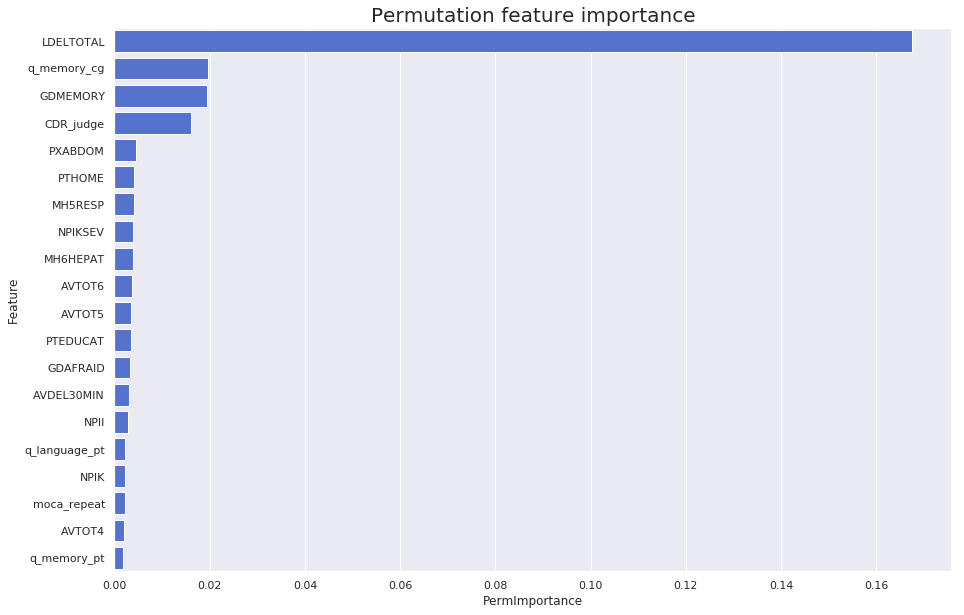

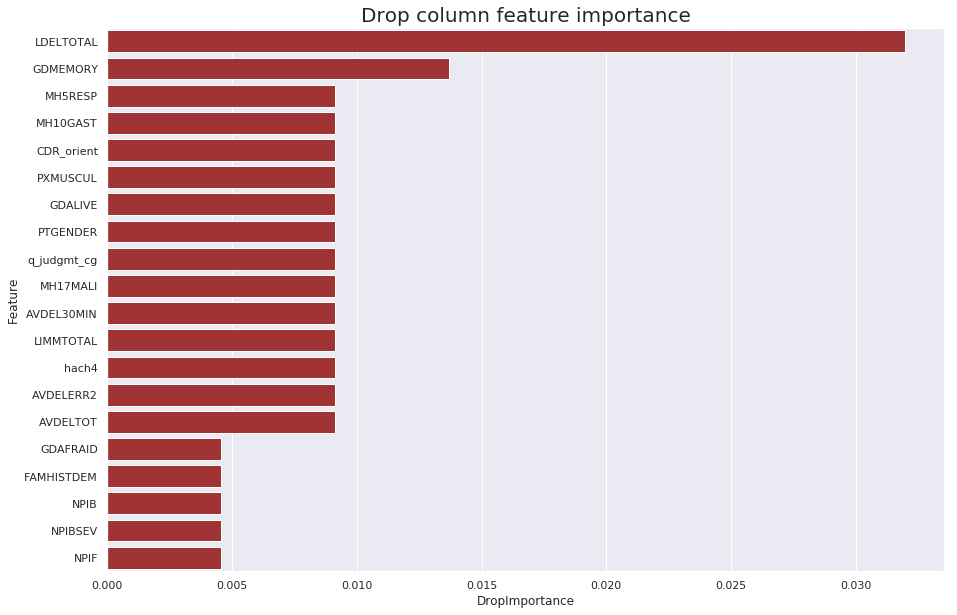

In [0]:
features_all_2 = ehr_feature(df_adni_X_scale, df_adni_y2, clf='rf')

In [0]:
features_all_2.to_csv(f'{dir}/Output/features_all_2_nocdrmem2.csv', index=False)

#### Ternary (AD/MCI/NL)

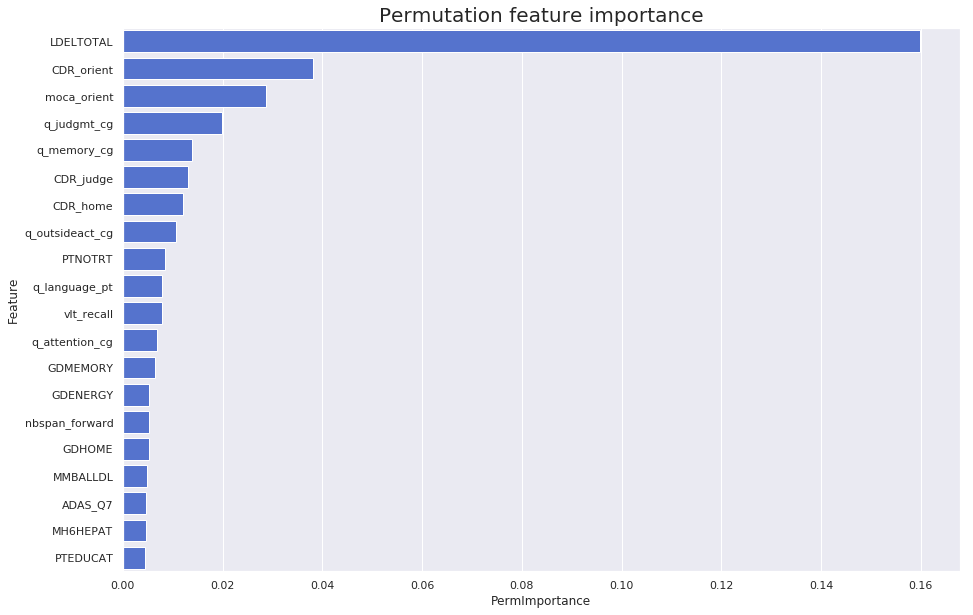

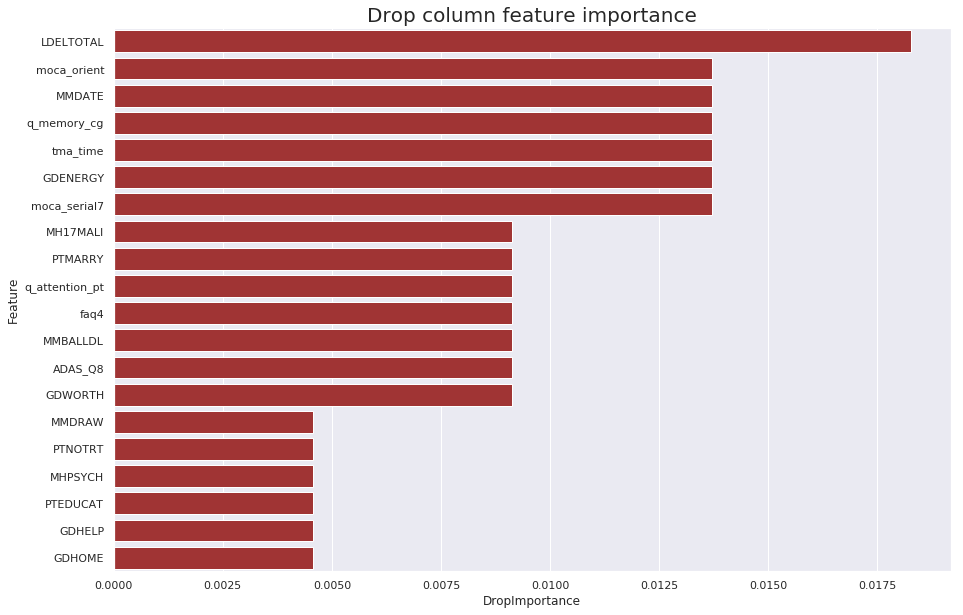

In [0]:
features_all_3 = ehr_feature(df_adni_X_scale, df_adni_y3, clf='xgb')

In [0]:
features_all_3.to_csv(f'{dir}/Output/features_all_3_nocdrmem2.csv', index=False)

### Cognitive Exam Features

In [0]:
adni_X_cols = ['moca_visuo_exec', 'moca_clock',
       'moca_naming', 'moca_digits', 'moca_letters', 'moca_serial7',
       'moca_repeat', 'moca_fluency', 'moca_similarities', 'moca_recall',
       'moca_orient', 'ADAS_Q1', 'ADAS_Q2',
       'ADAS_Q3', 'ADAS_Q4', 'ADAS_Q5', 'ADAS_Q6', 'ADAS_Q7', 'ADAS_Q8',
       'ADAS_Q9', 'ADAS_Q10', 'ADAS_Q11', 'ADAS_Q12', 'ADAS_Q13',
       'MMDATE', 'MMYEAR', 'MMMONTH', 'MMDAY', 'MMSEASON', 'MMHOSPIT', 'MMFLOOR',
       'MMCITY', 'MMAREA', 'MMSTATE', 'MMBALL', 'MMFLAG', 'MMTREE', 'MMD',
       'MML', 'MMR', 'MMO', 'MMW', 'MMBALLDL', 'MMFLAGDL', 'MMTREEDL',
       'MMWATCH', 'MMPENCIL', 'MMREPEAT', 'MMHAND', 'MMFOLD', 'MMONFLR',
       'MMREAD', 'MMWRITE', 'MMDRAW', 'CDR_orient', 'CDR_judge', 'CDR_comm',
       'CDR_home', 'CDR_care', 'CLOCKCIRC', 'CLOCKSYM',
       'CLOCKNUM', 'CLOCKHAND', 'CLOCKTIME', 'COPYCIRC', 'COPYSYM',
       'COPYNUM', 'COPYHAND', 'COPYTIME', 'AVTOT1', 'AVTOT2', 'AVTOT3',
       'AVTOT4', 'AVTOT5', 'AVTOT6', 'nbspan_forward', 'nbspan_backward',
       'CATANIMSC', 'CATVEGESC', 'tma_time', 'tmb_time', 'TRAAERRCOM',
       'TRAAERROM', 'TRABERRCOM', 'TRABERROM', 'LIMMTOTAL', 'LDELTOTAL',
       'AVDEL30MIN', 'AVDELTOT', 'AVDELERR2', 'vlt_recall']
df_adni_X = df_adni.loc[:,adni_X_cols]
df_adni_y2 = df_adni.loc[:,['Impaired']]
df_adni_y3 = df_adni.loc[:,['DX']]
df_adni_X_scale = df_adni_X_scaled.loc[:,adni_X_cols]

#### Binary (Impaired/Not)

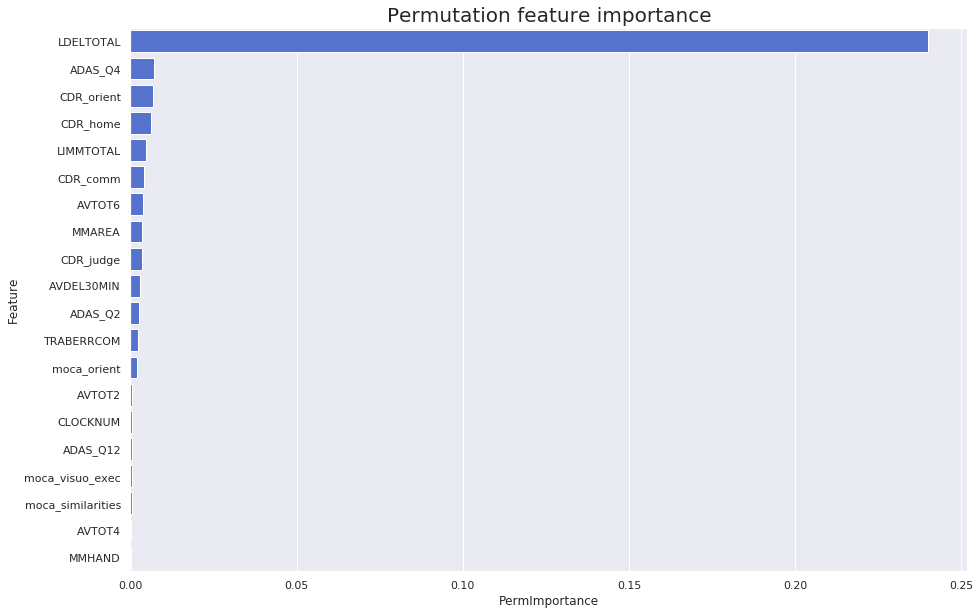

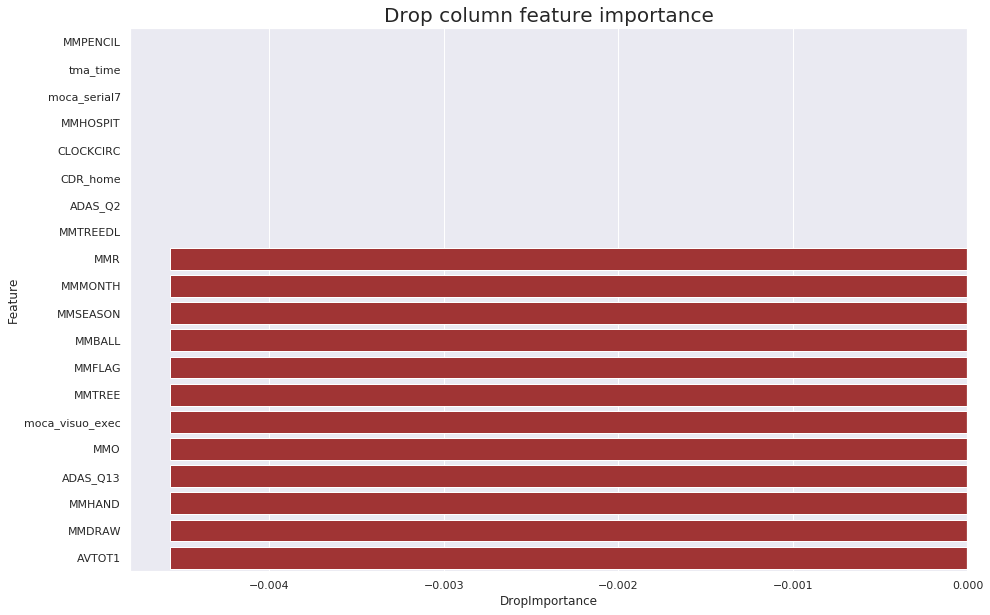

In [0]:
features_cog_2 = ehr_feature(df_adni_X_scale, df_adni_y2, clf='rf')

In [0]:
features_cog_2.to_csv(f'{dir}/Output/features_cog_2_nocdrmem.csv', index=False)

#### Ternary (AD/MCI/NL)

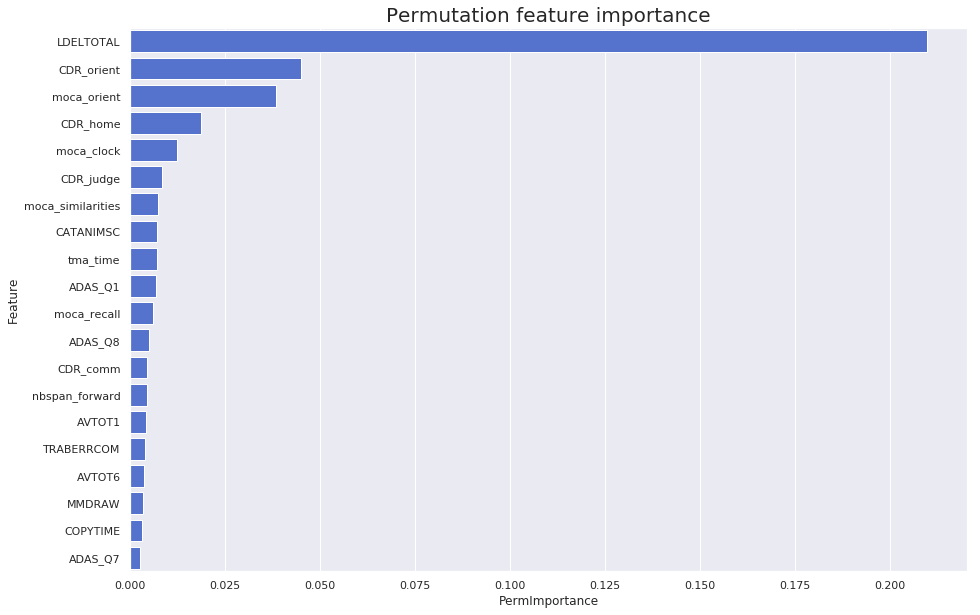

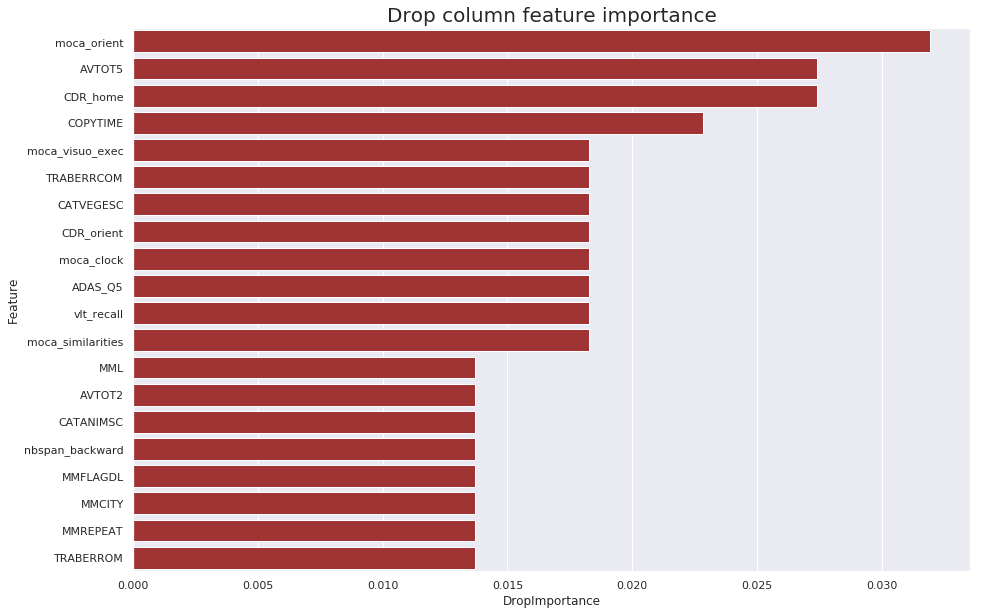

In [0]:
features_cog_3 = ehr_feature(df_adni_X_scale, df_adni_y3, clf='xgb')

In [0]:
features_cog_3.to_csv(f'{dir}/Output/features_cog_3_nocdrmem.csv', index=False)

### Questionnaire Features (split/all)

In [0]:
adni_X_cols = ['MEM1_pt',
       'MEM2_pt', 'MEM3_pt', 'MEM4_pt', 'MEM5_pt', 'MEM6_pt', 'MEM7_pt',
       'MEM8_pt', 'LANG1_pt', 'LANG2_pt', 'LANG3_pt', 'LANG4_pt',
       'LANG5_pt', 'LANG6_pt', 'LANG7_pt', 'LANG8_pt', 'LANG9_pt',
       'VISSPAT1_pt', 'VISSPAT2_pt', 'VISSPAT3_pt', 'VISSPAT4_pt',
       'VISSPAT5_pt', 'VISSPAT6_pt', 'VISSPAT7_pt', 'VISSPAT8_pt',
       'PLAN1_pt', 'PLAN2_pt', 'PLAN3_pt', 'PLAN4_pt', 'PLAN5_pt',
       'ORGAN1_pt', 'ORGAN2_pt', 'ORGAN3_pt', 'ORGAN4_pt', 'ORGAN5_pt',
       'ORGAN6_pt', 'DIVATT1_pt', 'DIVATT2_pt', 'DIVATT3_pt',
       'DIVATT4_pt', 'MEM1_cg', 'MEM2_cg', 'MEM3_cg', 'MEM4_cg',
       'MEM5_cg', 'MEM6_cg', 'MEM7_cg', 'MEM8_cg', 'LANG1_cg', 'LANG2_cg',
       'LANG3_cg', 'LANG4_cg', 'LANG5_cg', 'LANG6_cg', 'LANG7_cg',
       'LANG8_cg', 'LANG9_cg', 'VISSPAT1_cg', 'VISSPAT2_cg',
       'VISSPAT3_cg', 'VISSPAT4_cg', 'VISSPAT5_cg', 'VISSPAT6_cg',
       'VISSPAT7_cg', 'VISSPAT8_cg', 'PLAN1_cg', 'PLAN2_cg', 'PLAN3_cg',
       'PLAN4_cg', 'PLAN5_cg', 'ORGAN1_cg', 'ORGAN2_cg', 'ORGAN3_cg',
       'ORGAN4_cg', 'ORGAN5_cg', 'ORGAN6_cg', 'DIVATT1_cg', 'DIVATT2_cg',
       'DIVATT3_cg', 'DIVATT4_cg']
df_adni_X = df_adni.loc[:,adni_X_cols]
df_adni_X_scale = df_adni_X_scaled.loc[:,adni_X_cols]

#### Binary (Impaired/Not)

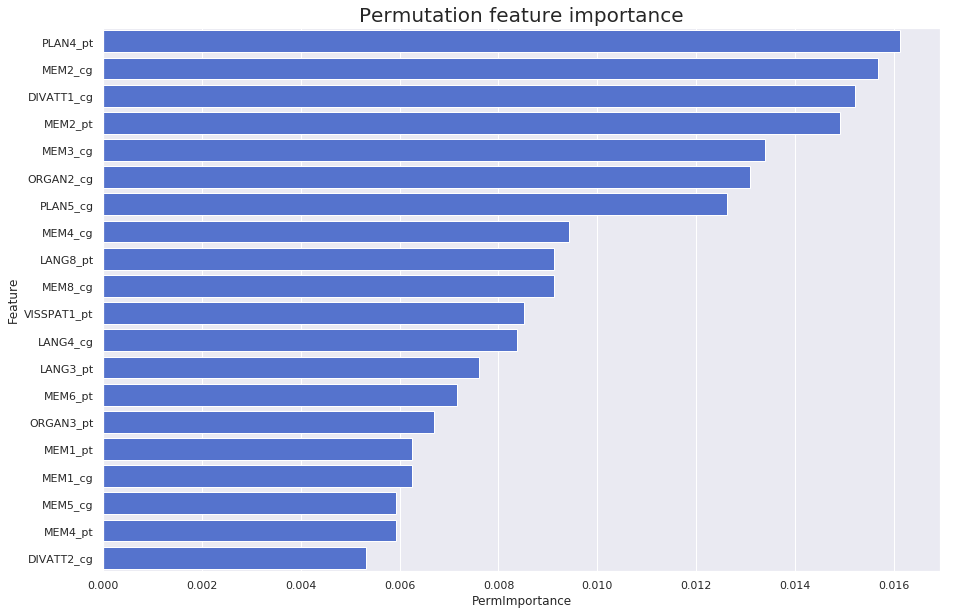

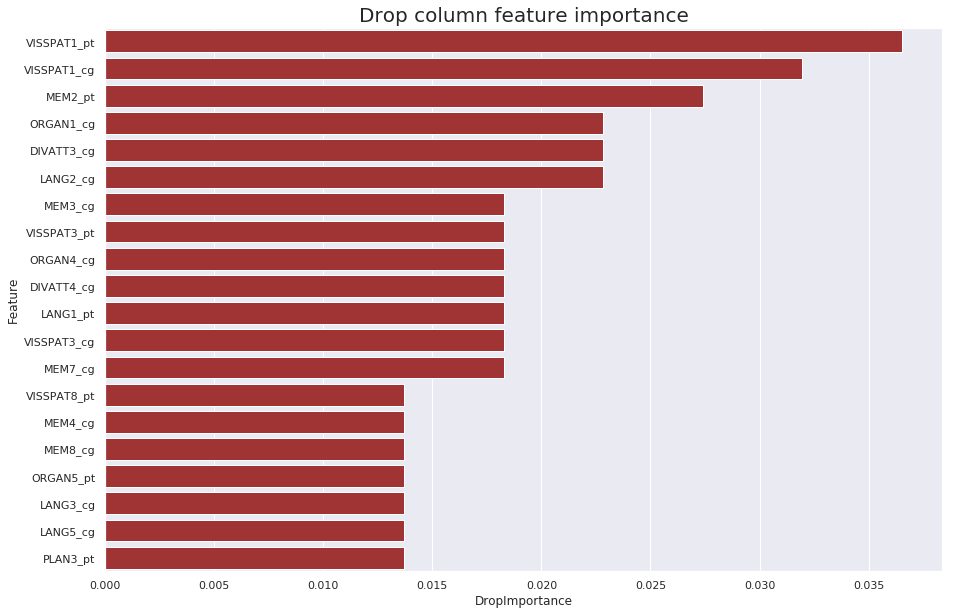

In [0]:
features_ques_2 = ehr_feature(df_adni_X_scale, df_adni_y2, clf='xgb')

In [0]:
features_ques_2.to_csv(f'{dir}/Output/features_ques_2.csv', index=False)

#### Ternary (AD/MCI/NL)

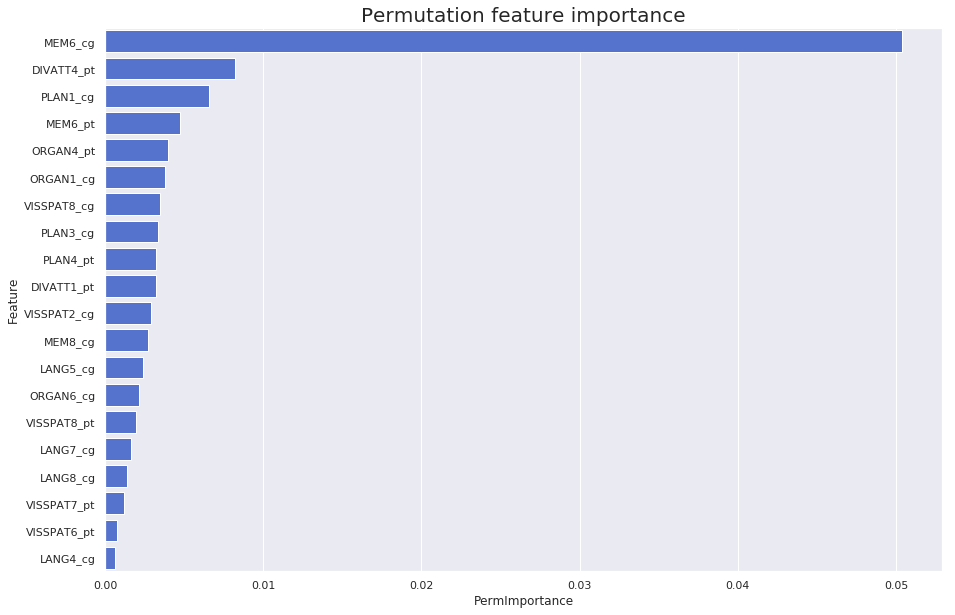

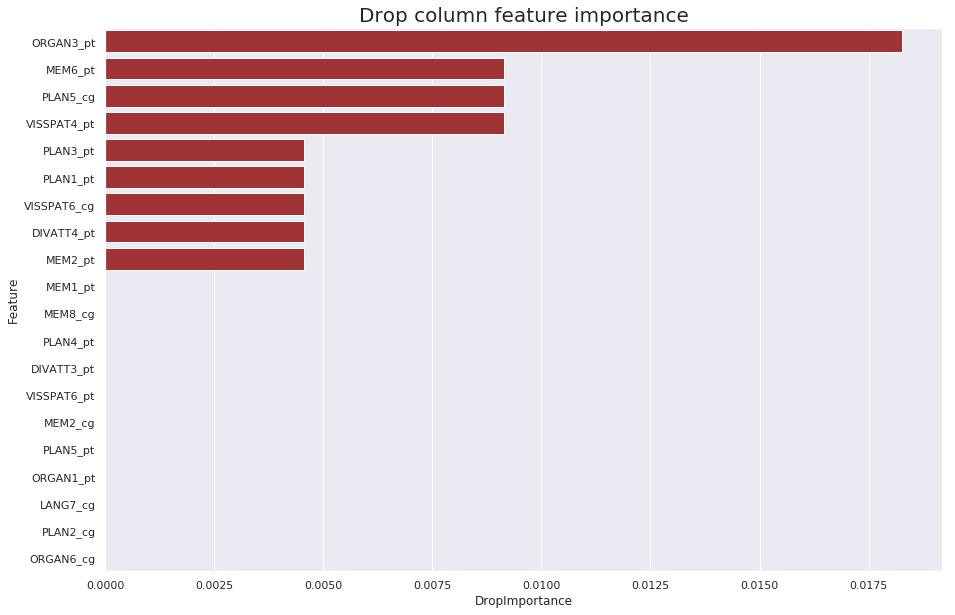

In [0]:
features_ques_3 = ehr_feature(df_adni_X_scale, df_adni_y3, clf='xgb')

In [0]:
features_ques_3.to_csv(f'{dir}/Output/features_ques_3.csv', index=False)

### Questionnaire Features (QDRS like)

In [0]:
adni_X_cols = ['q_memory_pt', 'q_orient_pt',
       'q_judgmt_pt', 'q_outsideact_pt', 'q_homeact_pt', 'q_language_pt',
       'q_attention_pt', 'q_memory_cg', 'q_orient_cg',
       'q_judgmt_cg', 'q_outsideact_cg', 'q_homeact_cg', 'q_language_cg',
       'q_attention_cg']
df_adni_X = df_adni.loc[:,adni_X_cols]
df_adni_X_scale = df_adni_X_scaled.loc[:,adni_X_cols]

#### Binary (Impaired/Not)

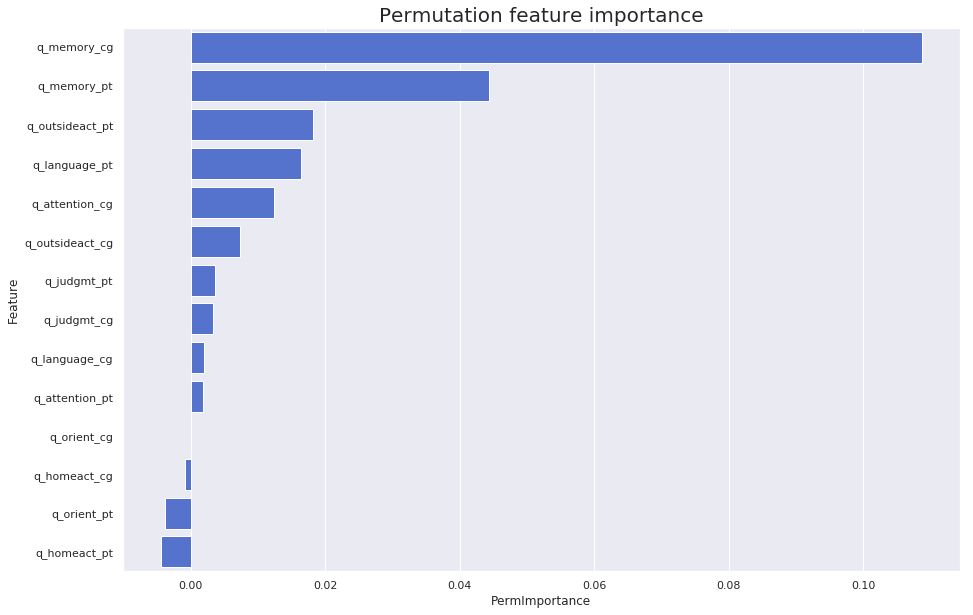

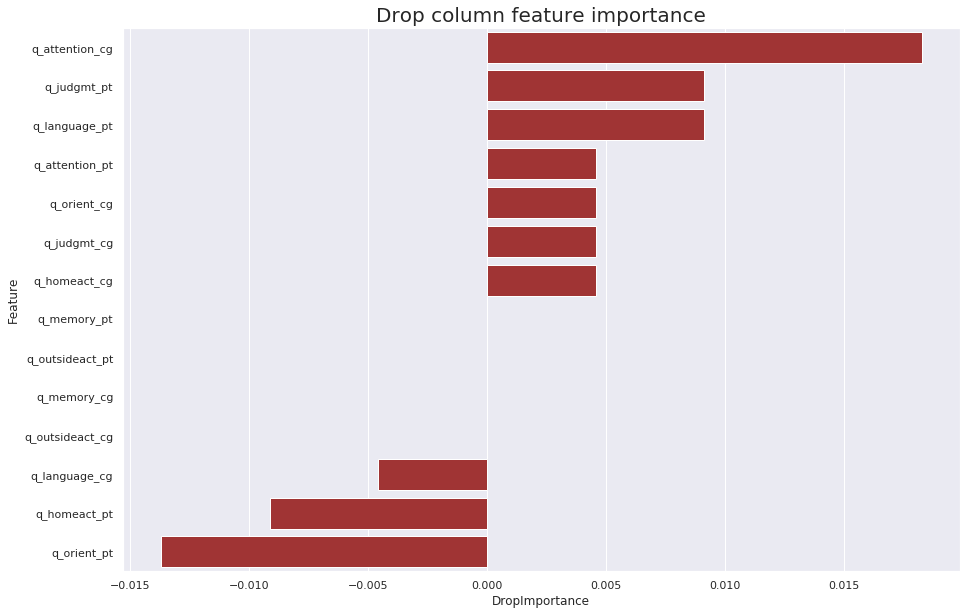

In [0]:
features_ques_2 = ehr_feature(df_adni_X_scale, df_adni_y2, clf='xgb')

In [0]:
features_ques_2.to_csv(f'{dir}/Output/features_ques_qdrslike_2.csv', index=False)

#### Ternary (AD/MCI/NL)

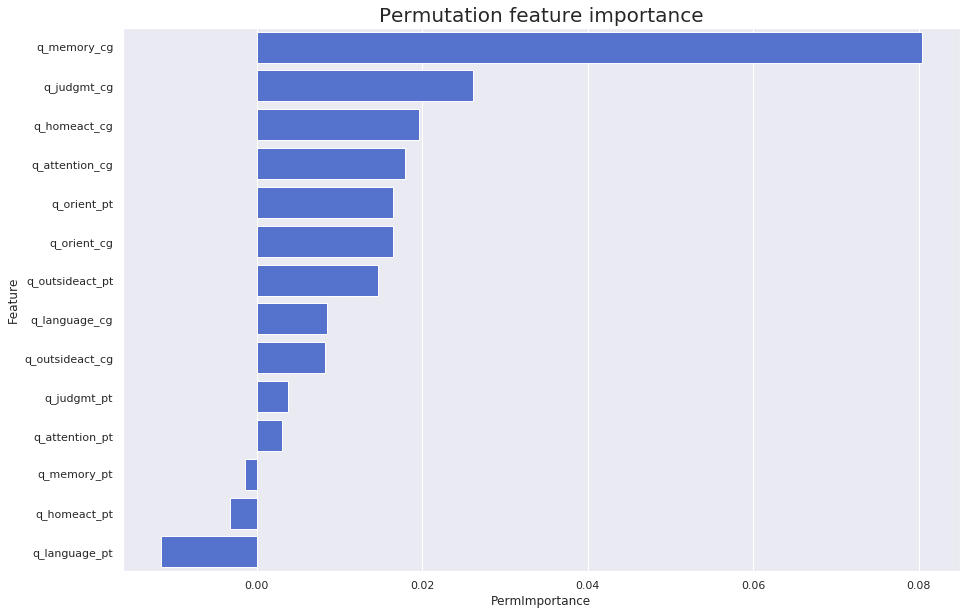

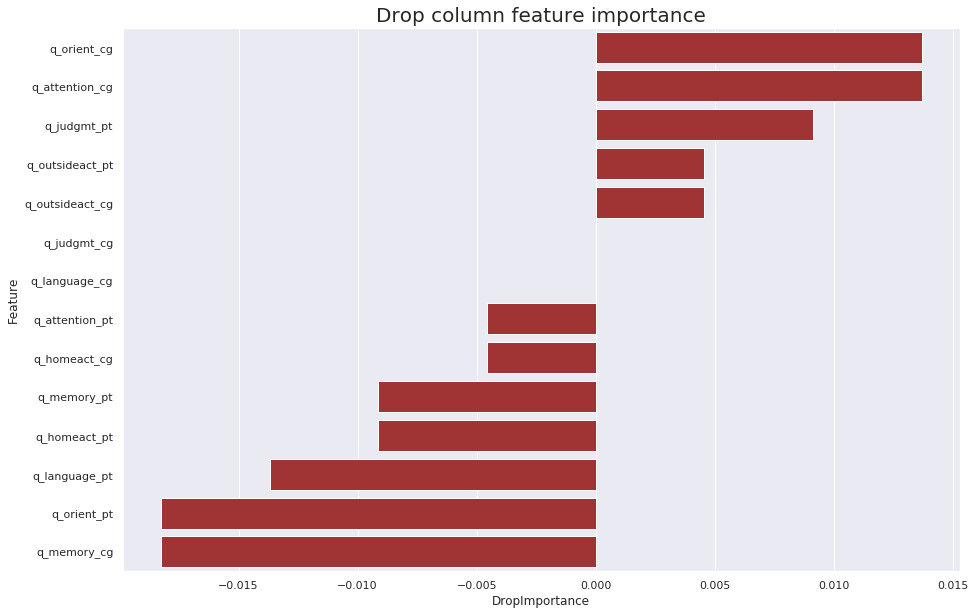

In [0]:
features_ques_3 = ehr_feature(df_adni_X_scale, df_adni_y3, clf='xgb')

In [0]:
features_ques_3.to_csv(f'{dir}/Output/features_ques_qdrslike_3.csv', index=False)

### Lifestyle Features

In [0]:
adni_X_cols = ['faq1', 'faq2', 'faq3', 'faq4',
       'faq5', 'faq6', 'faq7', 'faq8', 'faq9', 'faq10']
df_adni_X = df_adni.loc[:,adni_X_cols]
df_adni_y2 = df_adni.loc[:,['Impaired']]
df_adni_y3 = df_adni.loc[:,['DX']]
df_adni_X_scale = df_adni_X_scaled.loc[:,adni_X_cols]

#### Binary (Impaired/Not)

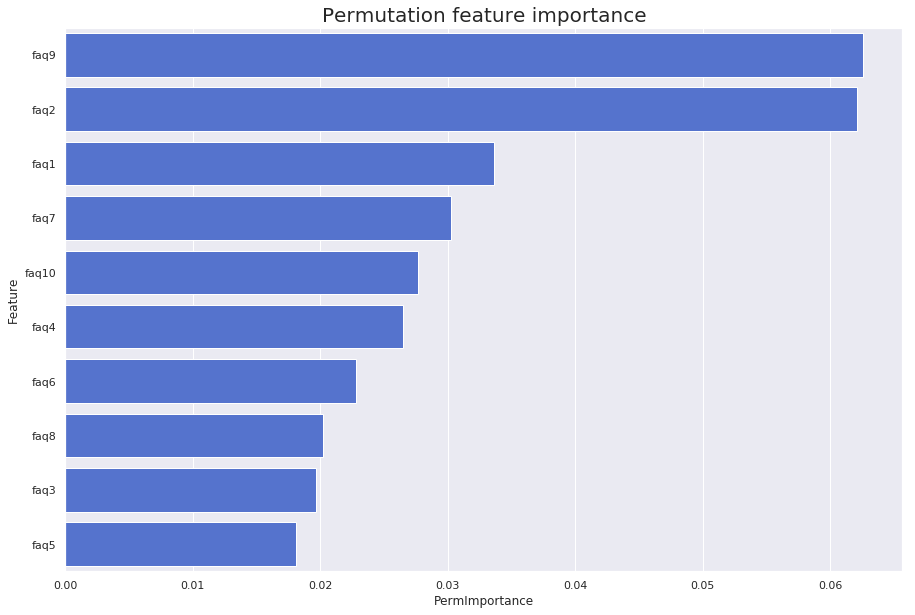

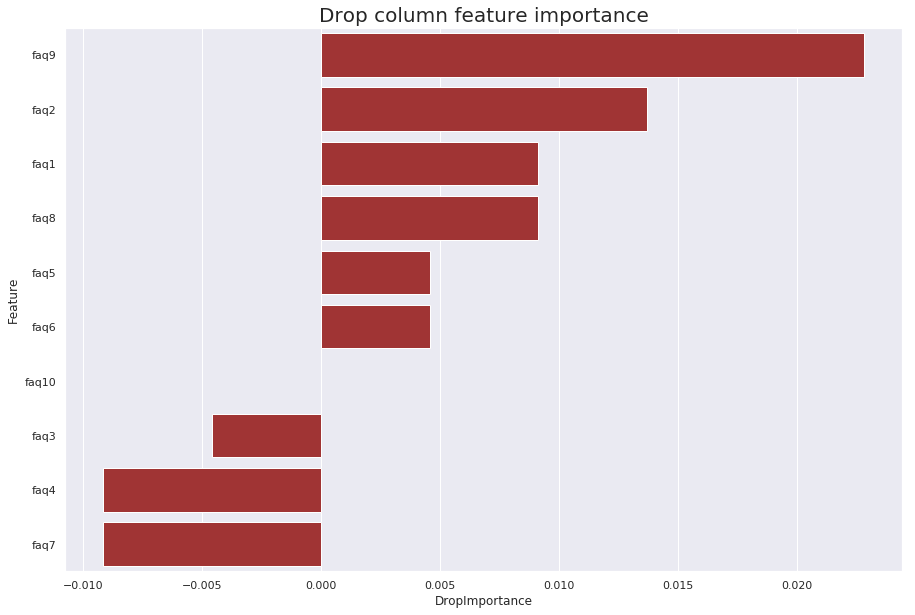

In [0]:
features_func_2 = ehr_feature(df_adni_X_scale, df_adni_y2, clf='xgb')

In [0]:
features_func_2.to_csv(f'{dir}/Output/features_func_2.csv', index=False)

#### Ternary (AD/MCI/NL)

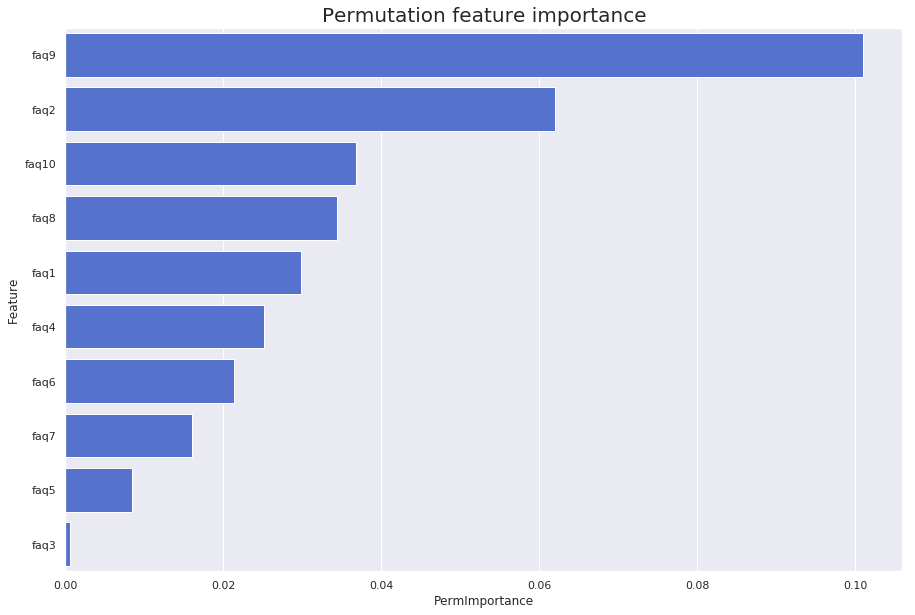

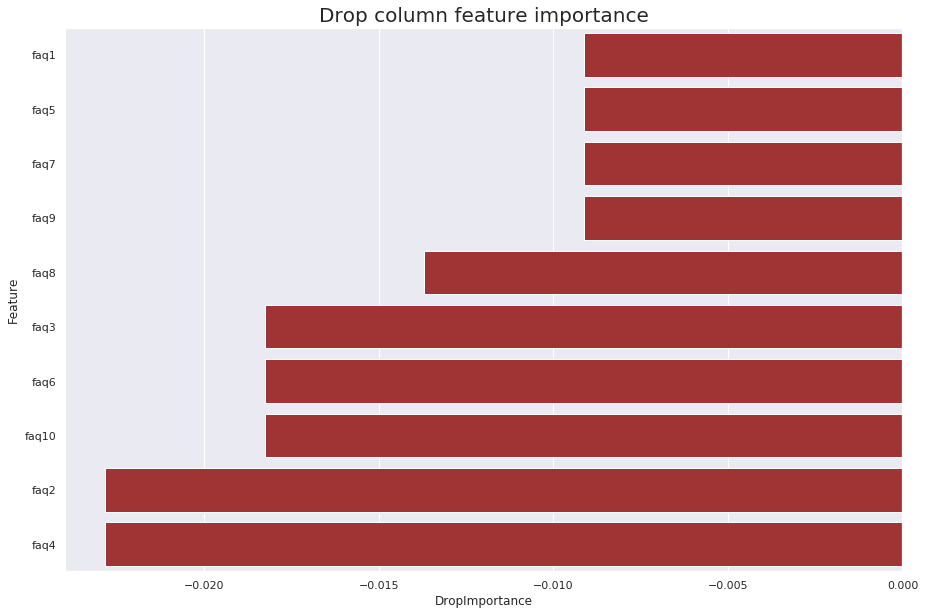

In [0]:
features_func_3 = ehr_feature(df_adni_X_scale, df_adni_y3, clf='xgb')

In [0]:
features_func_3.to_csv(f'{dir}/Output/features_func_3.csv', index=False)

### All Questionnaires

In [0]:
adni_X_cols = ['q_memory_pt', 'q_orient_pt',
       'q_judgmt_pt', 'q_outsideact_pt', 'q_homeact_pt', 'q_language_pt',
       'q_attention_pt', 'q_memory_cg', 'q_orient_cg',
       'q_judgmt_cg', 'q_outsideact_cg', 'q_homeact_cg', 'q_language_cg',
       'q_attention_cg','faq1', 'faq2', 'faq3', 'faq4',
       'faq5', 'faq6', 'faq7', 'faq8', 'faq9', 'faq10']
df_adni_X = df_adni.loc[:,adni_X_cols]
df_adni_X_scale = df_adni_X_scaled.loc[:,adni_X_cols]

#### Binary (Impaired/Not)

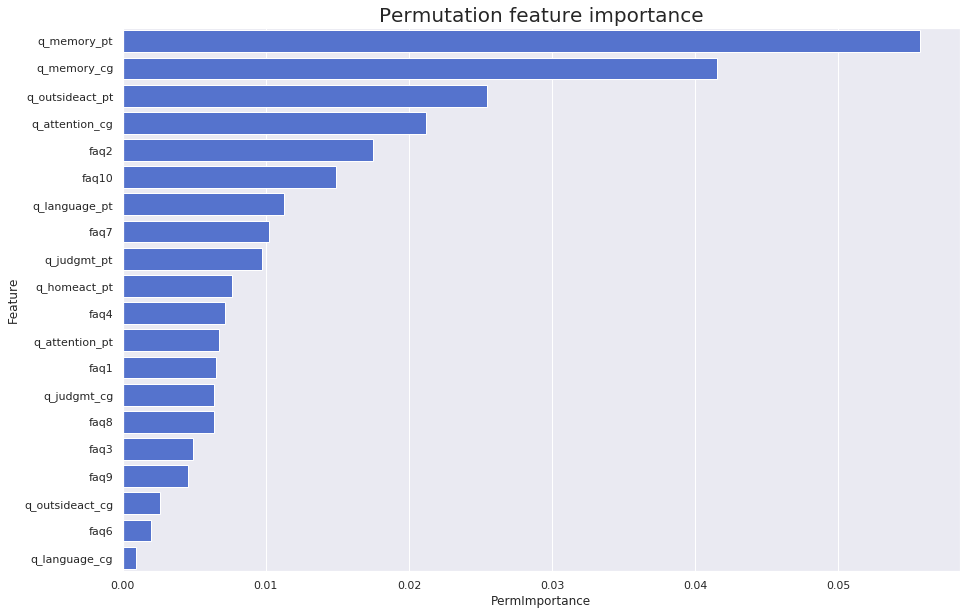

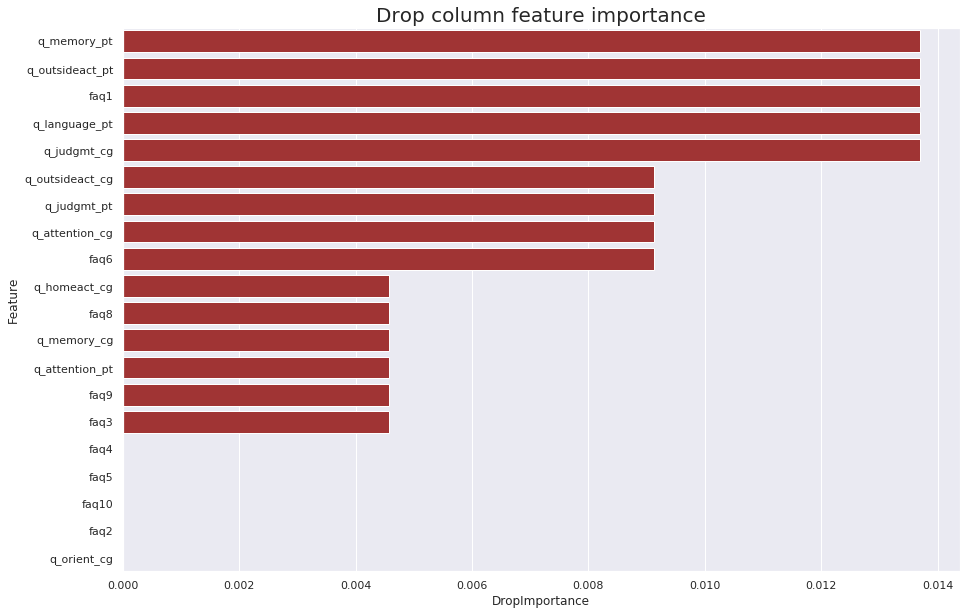

In [0]:
features_allques_2 = ehr_feature(df_adni_X_scale, df_adni_y2, clf='xgb')

In [0]:
features_allques_2.to_csv(f'{dir}/Output/features_allques_2.csv', index=False)

#### Ternary (AD/MCI/NL)

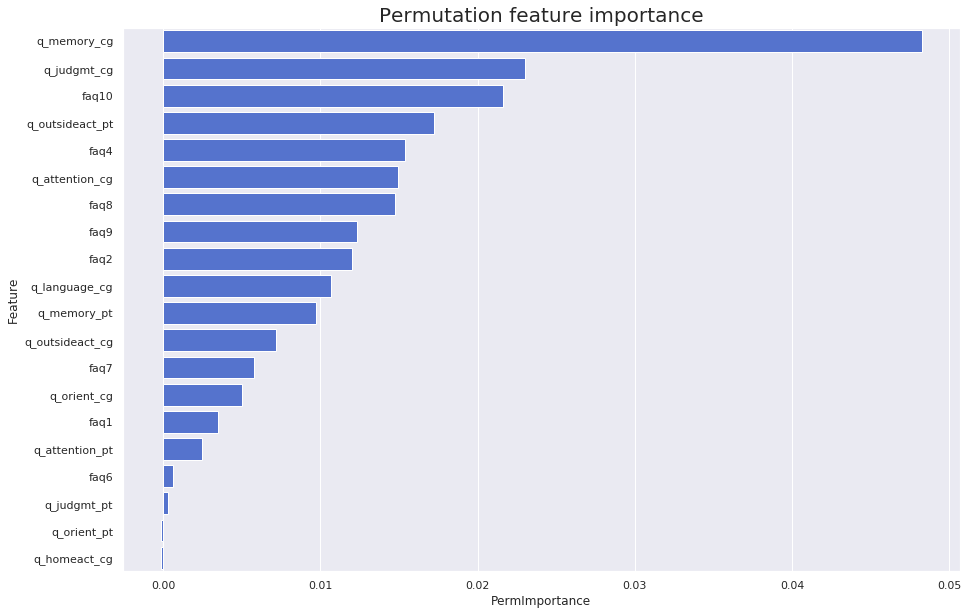

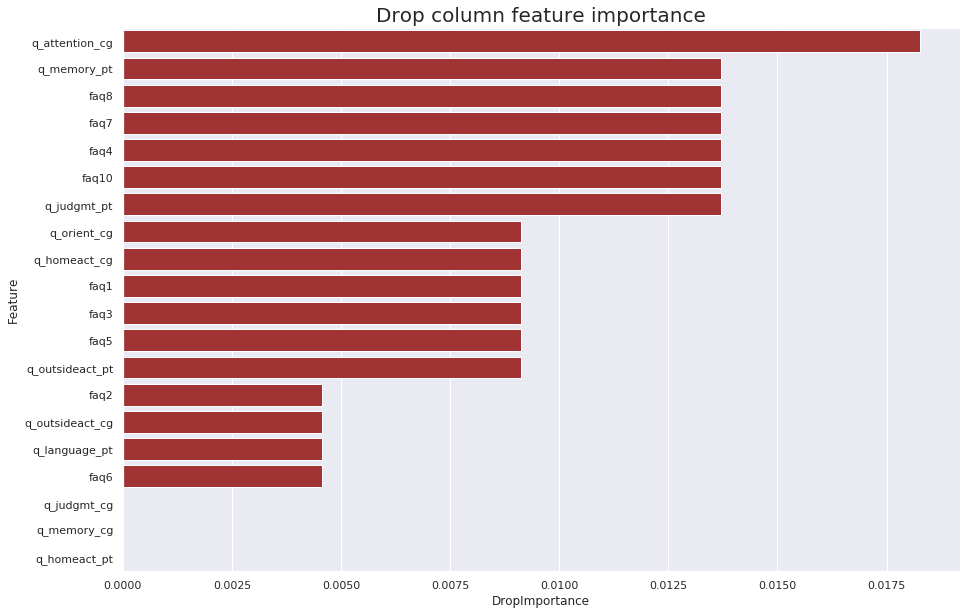

In [0]:
features_allques_3 = ehr_feature(df_adni_X_scale, df_adni_y3, clf='xgb')

In [0]:
features_allques_3.to_csv(f'{dir}/Output/features_allques_3.csv', index=False)

### Mental Exam Features

In [0]:
adni_X_cols = ['GDSATIS', 'GDDROP', 'GDEMPTY',
       'GDBORED', 'GDSPIRIT', 'GDAFRAID', 'GDHAPPY', 'GDHELP', 'GDHOME',
       'GDMEMORY', 'GDALIVE', 'GDWORTH', 'GDENERGY', 'GDHOPE', 'GDBETTER',
       'hach1', 'hach2', 'hach3', 'hach4', 'hach5', 'hach6', 'hach7',
       'hach8', 'NPIA',
       'NPIASEV', 'NPIB', 'NPIBSEV', 'NPIC', 'NPICSEV', 'NPID', 'NPIDSEV',
       'NPIE', 'NPIESEV', 'NPIF', 'NPIFSEV', 'NPIG', 'NPIGSEV', 'NPIH',
       'NPIHSEV', 'NPII', 'NPIISEV', 'NPIJ', 'NPIJSEV', 'NPIK', 'NPIKSEV',
       'NPIL', 'NPILSEV']
df_adni_X = df_adni.loc[:,adni_X_cols]
df_adni_y2 = df_adni.loc[:,['Impaired']]
df_adni_y3 = df_adni.loc[:,['DX']]
df_adni_X_scale = df_adni_X_scaled.loc[:,adni_X_cols]

#### Binary (Impaired/Not)

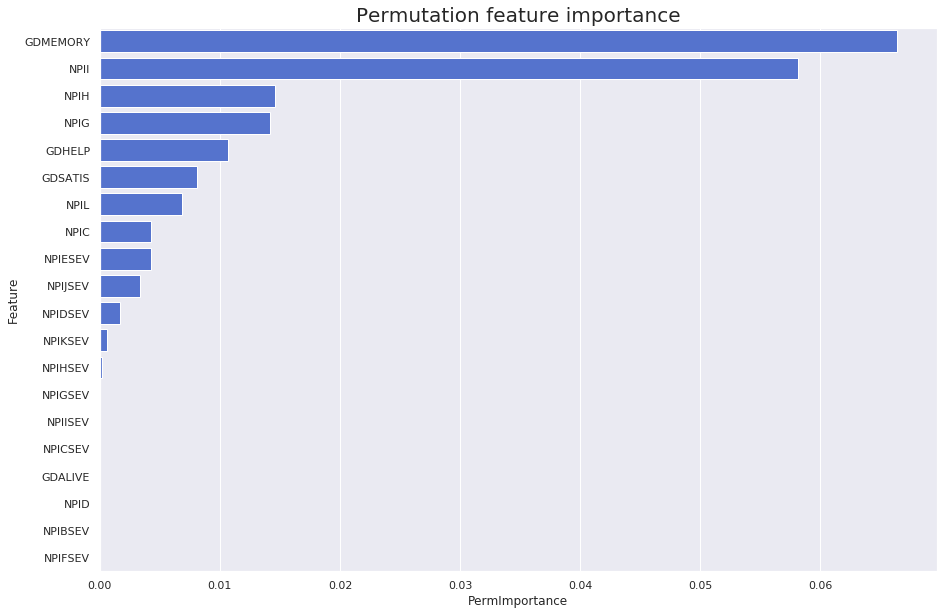

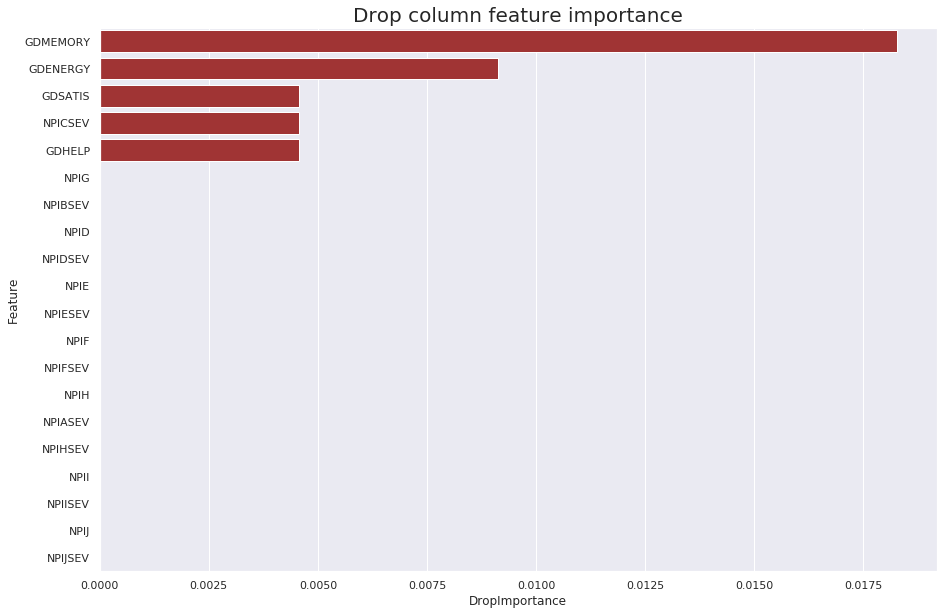

In [0]:
features_mental_2 = ehr_feature(df_adni_X_scale, df_adni_y2, clf='xgb')

In [0]:
features_mental_2.to_csv(f'{dir}/Output/features_mental_2.csv', index=False)

#### Ternary (AD/MCI/NL)

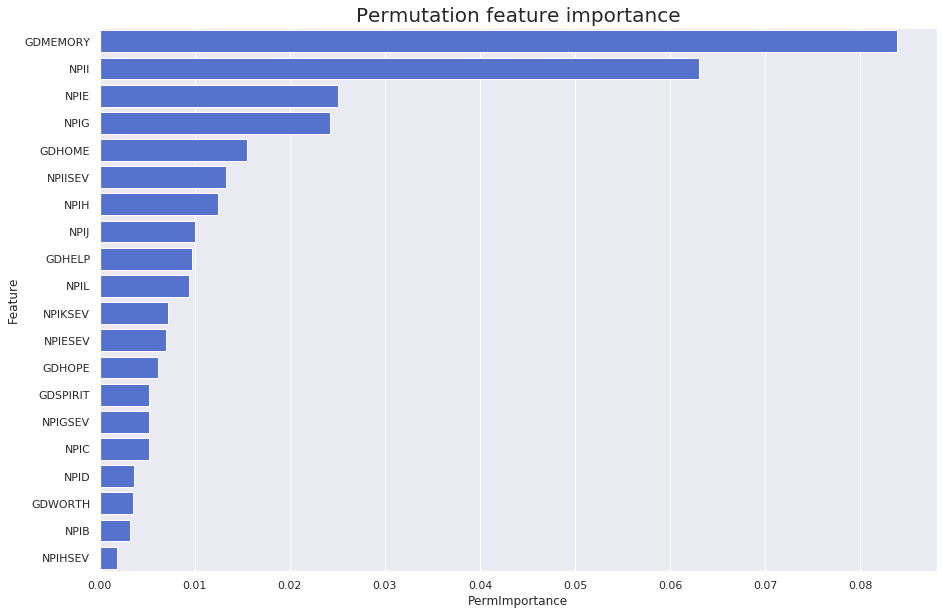

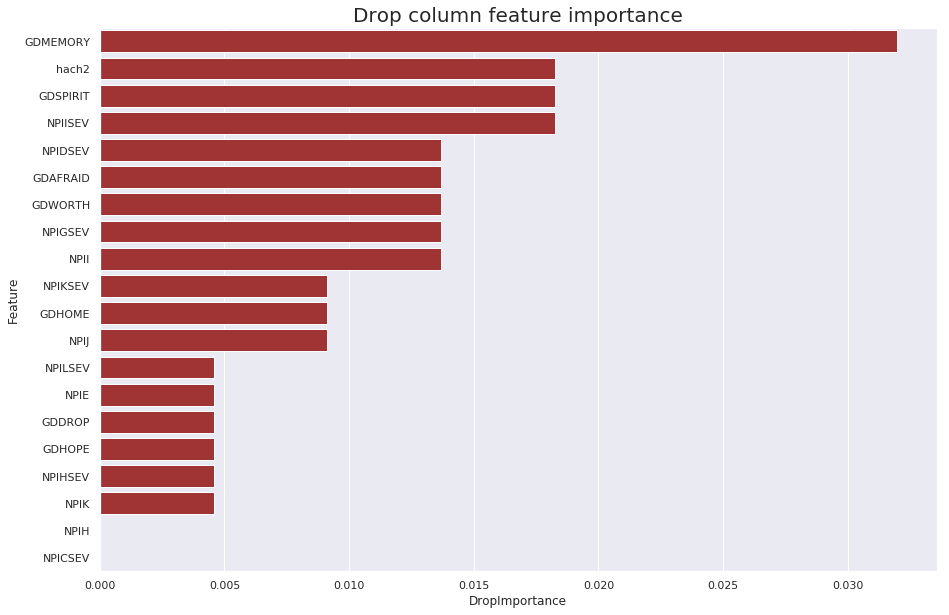

In [0]:
features_mental_3 = ehr_feature(df_adni_X_scale, df_adni_y3, clf='xgb')

In [0]:
features_mental_3.to_csv(f'{dir}/Output/features_mental_3.csv', index=False)

### Physical Exam Features

In [0]:
adni_X_cols = ['PXGENAPP', 'PXHEADEY', 'PXNECK', 'PXCHEST', 'PXHEART',
       'PXABDOM', 'PXEXTREM', 'PXPERIPH', 'PXSKIN', 'PXMUSCUL']
df_adni_X = df_adni.loc[:,adni_X_cols]
df_adni_y2 = df_adni.loc[:,['Impaired']]
df_adni_y3 = df_adni.loc[:,['DX']]
df_adni_X_scale = df_adni_X_scaled.loc[:,adni_X_cols]

#### Binary (Impaired/Not)

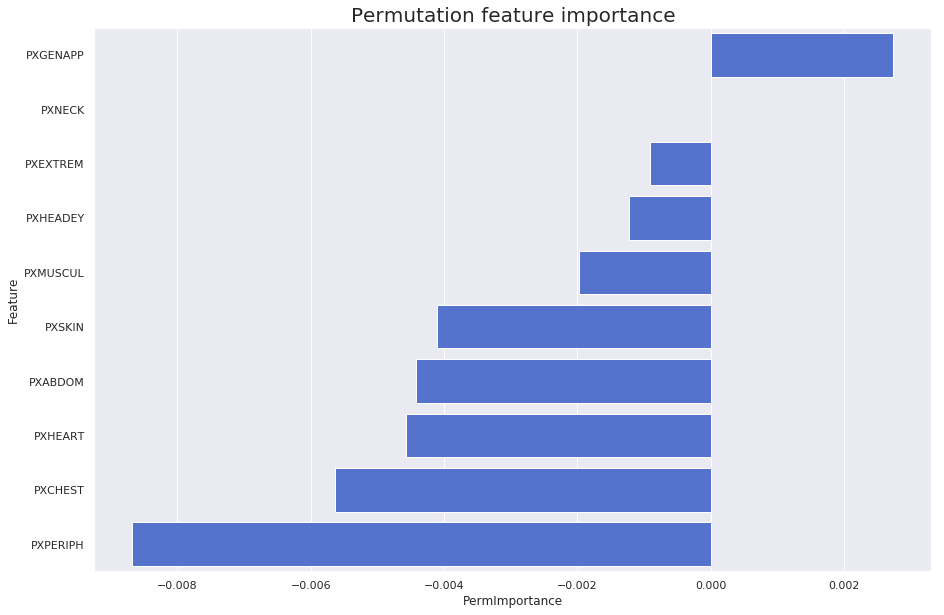

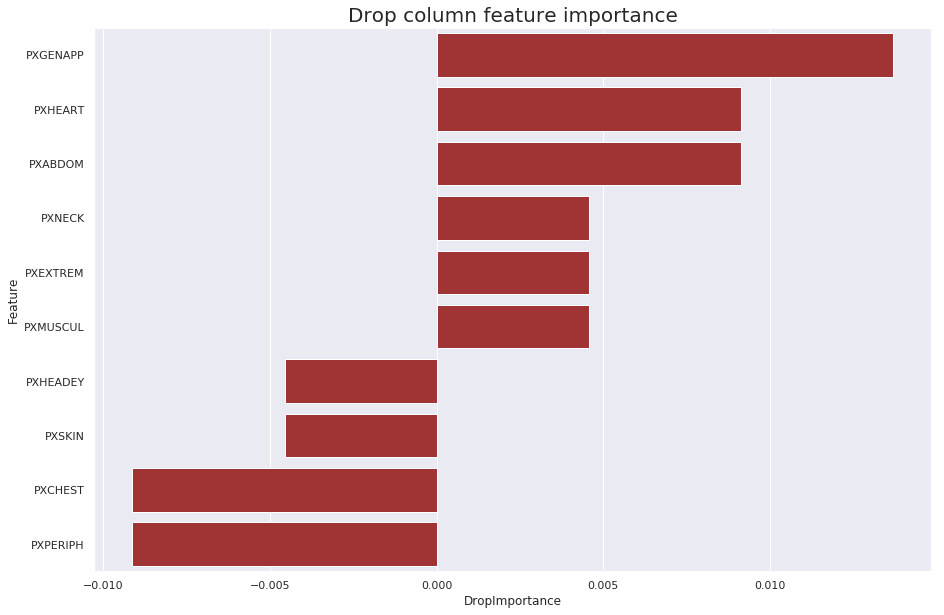

In [0]:
features_phys_2 = ehr_feature(df_adni_X_scale, df_adni_y2, clf='xgb')

In [0]:
features_phys_2.to_csv(f'{dir}/Output/features_phys_2.csv', index=False)

#### Ternary (AD/MCI/NL)

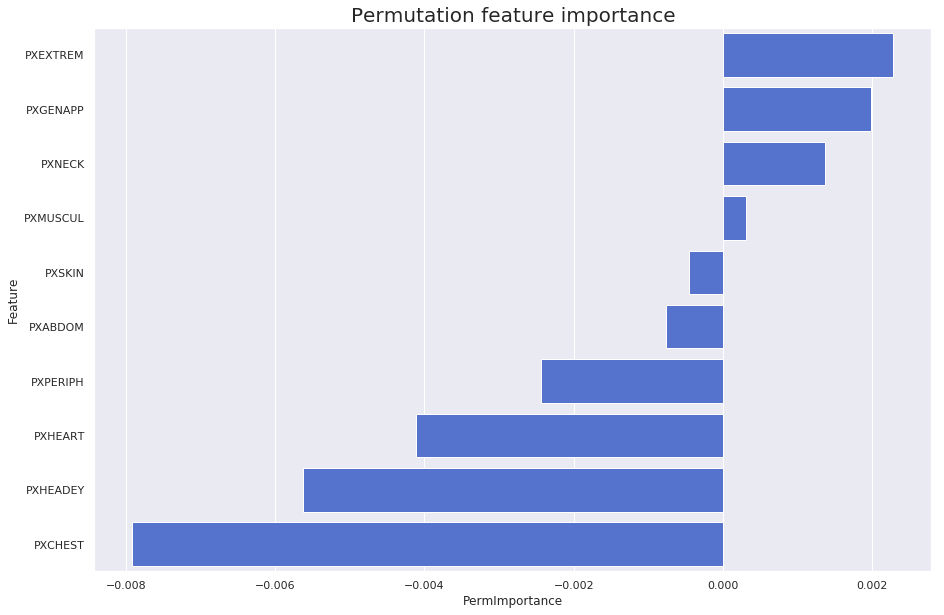

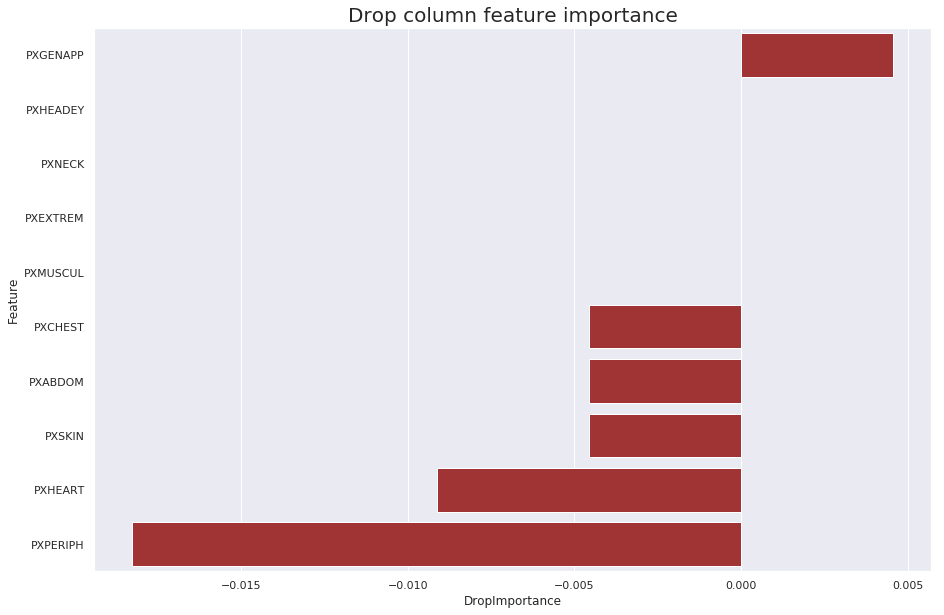

In [0]:
features_phys_3 = ehr_feature(df_adni_X_scale, df_adni_y3, clf='xgb')

In [0]:
features_phys_3.to_csv(f'{dir}/Output/features_phys_3.csv', index=False)

### Demographics Features

In [0]:
adni_X_cols = ['PTGENDER', 'PTHAND', 'PTMARRY',
       'PTEDUCAT', 'PTNOTRT', 'PTHOME', 'PTETHCAT', 'PTRACCAT', 'MHPSYCH',
       'MH2NEURL', 'MH3HEAD', 'MH4CARD', 'MH5RESP', 'MH6HEPAT', 'MH7DERM',
       'MH8MUSCL', 'MH9ENDO', 'MH10GAST', 'MH11HEMA', 'MH12RENA',
       'MH13ALLE', 'MH14ALCH', 'MH15DRUG', 'MH16SMOK', 'MH17MALI',
       'MH18SURG', 'MH19OTHR', 'FAMHISTAD', 'FAMHISTDEM']
df_adni_X = df_adni.loc[:,adni_X_cols]
df_adni_y2 = df_adni.loc[:,['Impaired']]
df_adni_y3 = df_adni.loc[:,['DX']]
df_adni_X_scale = df_adni_X_scaled.loc[:,adni_X_cols]

#### Binary (Impaired/Not)

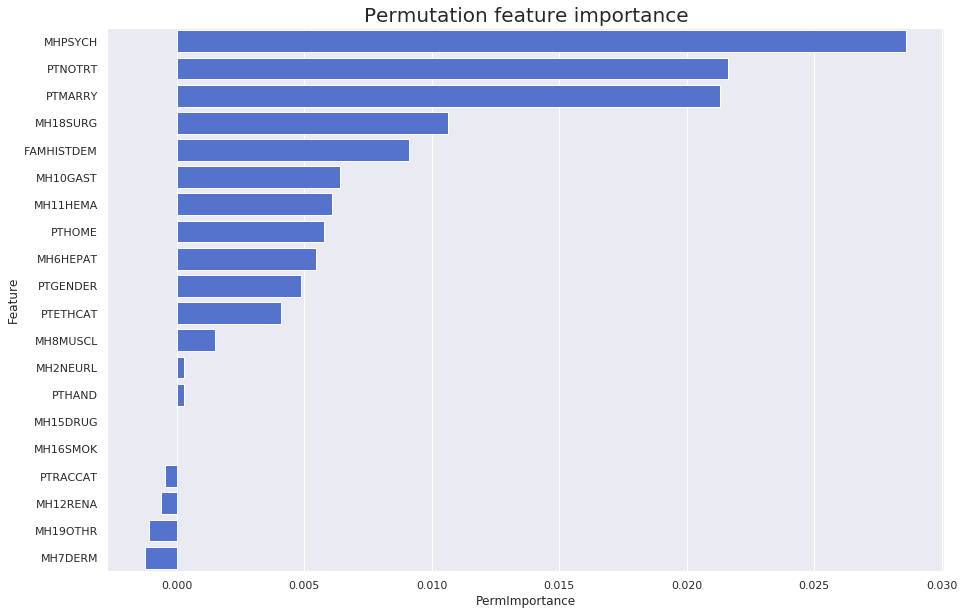

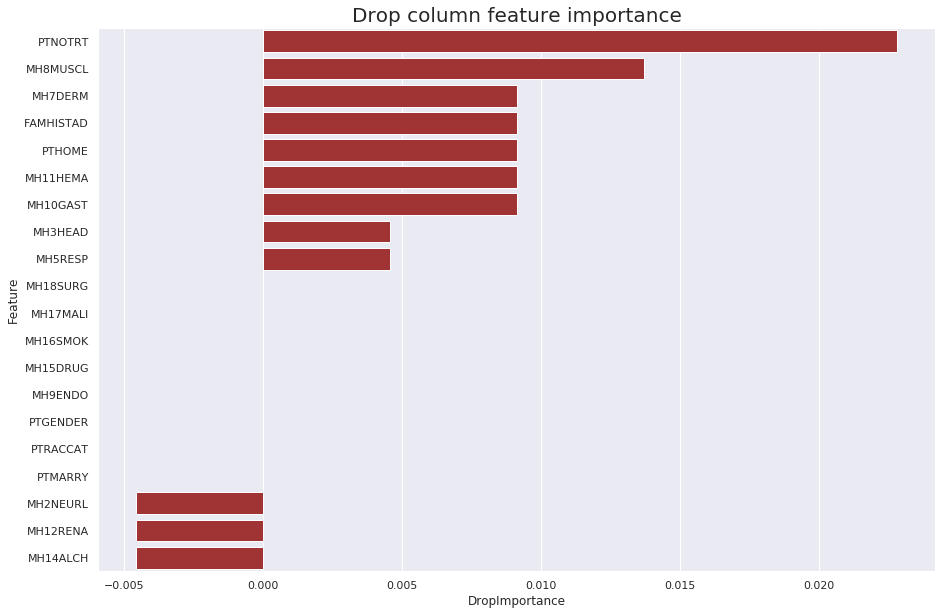

In [0]:
features_demogs_2 = ehr_feature(df_adni_X_scale, df_adni_y2, clf='xgb')

In [0]:
features_demogs_2.to_csv(f'{dir}/Output/features_demogs_2.csv', index=False)

#### Ternary (AD/MCI/NL)

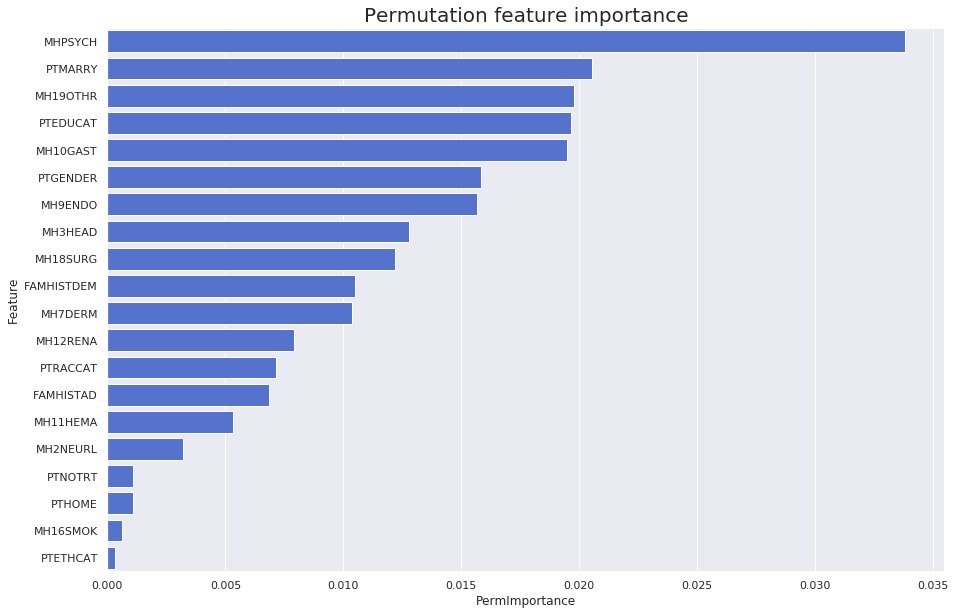

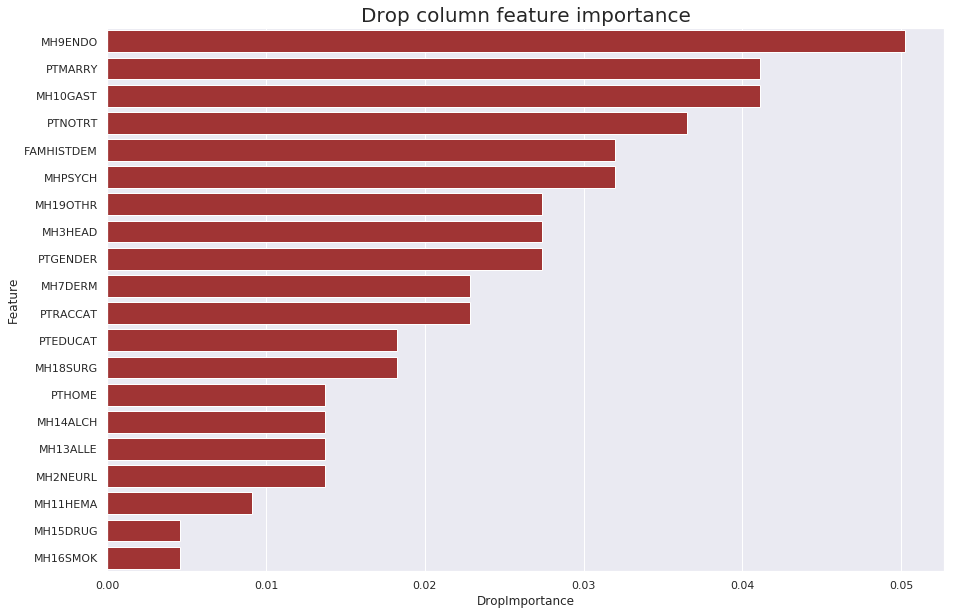

In [0]:
features_demogs_3 = ehr_feature(df_adni_X_scale, df_adni_y3, clf='xgb')

In [0]:
features_demogs_3.to_csv(f'{dir}/Output/features_demogs_3.csv', index=False)

# Paired Dataset

In [0]:
df_adni_pair_X = pd.read_csv(f'{dir}/Data/adni_pair_X.csv')
df_clinic_pair_X = pd.read_csv(f'{dir}/Data/clinic_pair_X.csv')
sm_clinic_pair_X = pd.read_csv(f'{dir}/Data/sm_clinic_pair_X.csv')

df_adni_pair_y2 = pd.read_csv(f'{dir}/Data/adni_pair_y2.csv')
df_adni_pair_y3 = pd.read_csv(f'{dir}/Data/adni_pair_y3.csv')

df_clinic_pair_y2 = pd.read_csv(f'{dir}/Data/clinic_pair_y2.csv')
df_clinic_pair_y3 = pd.read_csv(f'{dir}/Data/clinic_pair_y3.csv')
sm_clinic_pair_y2 = pd.read_csv(f'{dir}/Data/sm_clinic_pair_y2.csv', header=None)
sm_clinic_pair_y3 = pd.read_csv(f'{dir}/Data/sm_clinic_pair_y3.csv', header=None)

## SMOTE on Clinic

The most pressing issue with the Clinic dataset is the relative lack of subjects with normal cognition. While this doesn't affect the use of this dataset for testing purposes as much as its use as a training set, any algorithm derived from it is likely to predict "impaired" for every subject will achieve almost 90% accuracy. This is known as *class imbalance*. 

There are a few approaches towards addressing this issue. One is throwing away the samples from the overbalanced class until both classes are matching -- this will result in an extreme loss of data and very few overall samples, so this wouldn't be appropriate. Another approach is to take the underbalanced class and duplicate the data, referred to as **oversampling**. This technique can result in overfitting due to a potential reliance on artifacts in the data, but will not result in lost data or reduced sample counts.

We can address these potential artifacts by slightly modifying the data in the duplicated samples, so each subject is at least unique and not carbon copies replicated dozens of times. This is called SMOTE (Synthetic Minority Oversampling TEchnique) and we perform this using the python package "imbalanced-learn" or "imblearn"

In [0]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='minority', random_state=0)

sm_clinic_pair_X, sm_clinic_pair_y3 = sm.fit_resample(df_clinic_pair_X, 
                                                      df_clinic_pair_y3)
sm_clinic_pair_y2 = np.where(sm_clinic_pair_y3==2,1,sm_clinic_pair_y3)
sm_clinic_pair_X = pd.DataFrame(sm_clinic_pair_X, 
                                columns=df_clinic_pair_X.columns.values)

In [0]:
sm_clinic_pair_X.to_csv(f'{dir}/Data/sm_clinic_pair_X.csv', index=False)
np.savetxt(f'{dir}/Data/sm_clinic_pair_y2.csv', sm_clinic_pair_y2, delimiter=',')
np.savetxt(f'{dir}/Data/sm_clinic_pair_y3.csv', sm_clinic_pair_y3, delimiter=',')

## Analyses

In [0]:
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

from sklearn.model_selection import train_test_split as split

X_train, X_test, y2_train, y2_test = split(df_adni_pair_X, df_adni_pair_y2, test_size=0.33, random_state=5)
X_train, X_test, y3_train, y3_test = split(df_adni_pair_X, df_adni_pair_y3, test_size=0.33, random_state=5)

### SKLearn Approaches

In [0]:
clf = RandomForestClassifier(n_estimators=100, max_features=None, random_state=0)
clf.fit(X_train, y2_train.values.ravel())

y2_pred = clf.predict(X_test)
score = accuracy_score(y2_test, y2_pred)

print('ADNI Validation Accuracy: \t', score)
print('AUC: \t\t\t\t', (roc_auc_score(y2_test, y2_pred)))
print(confusion_matrix(y2_test, y2_pred))

clinic_y2_pred = clf.predict(sm_clinic_pair_X)
score = accuracy_score(sm_clinic_pair_y2, clinic_y2_pred)
print('Clinic Testing Accuracy: \t', score)
print('AUC: \t\t\t\t', roc_auc_score(sm_clinic_pair_y2, clinic_y2_pred))
print(confusion_matrix(sm_clinic_pair_y2, clinic_y2_pred))

ADNI Validation Accuracy: 	 0.8614958448753463
AUC: 				 0.8442999867672356
[[103  29]
 [ 21 208]]
Clinic Testing Accuracy: 	 0.7755775577557755
AUC: 				 0.7732584269662922
[[ 95  30]
 [ 38 140]]


In [0]:
clf = xgboost.XGBClassifier(objective='binary:logistic', random_state=0)
clf.fit(X_train, y2_train.values.ravel())

y2_pred = clf.predict(X_test)
score = accuracy_score(y2_test, y2_pred)

print('ADNI Validation Accuracy: \t', score)
print('AUC: \t\t\t\t', (roc_auc_score(y2_test, y2_pred)))
print(confusion_matrix(y2_test, y2_pred))

clinic_y2_pred = clf.predict(sm_clinic_pair_X)
score = accuracy_score(sm_clinic_pair_y2, clinic_y2_pred)
print('Clinic Testing Accuracy: \t', score)
print('AUC: \t\t\t\t', roc_auc_score(sm_clinic_pair_y2, clinic_y2_pred))
print(confusion_matrix(sm_clinic_pair_y2, clinic_y2_pred))


ADNI Validation Accuracy: 	 0.8642659279778393
AUC: 				 0.8529012835781393
[[107  25]
 [ 24 205]]
Clinic Testing Accuracy: 	 0.7722772277227723
AUC: 				 0.746629213483146
[[ 75  50]
 [ 19 159]]


In [0]:
# Random Forest -- CN,MCI,AD

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_features=0.5, random_state=0)
clf.fit(X_train, y3_train.values.ravel())

y3_pred = clf.predict(X_test)
score = accuracy_score(y3_test, y3_pred)

print('ADNI Validation Accuracy: ', score)
print(confusion_matrix(y3_test, y3_pred))

clinic_y3_pred = clf.predict(sm_clinic_pair_X)
score = accuracy_score(sm_clinic_pair_y3, clinic_y3_pred)
print('Clinic Testing Accuracy: ', score)
print(confusion_matrix(sm_clinic_pair_y3, clinic_y3_pred))

ADNI Validation Accuracy:  0.7867036011080333
[[104  28   0]
 [ 21 137   3]
 [  0  25  43]]
Clinic Testing Accuracy:  0.6237623762376238
[[68 54  3]
 [12 38  3]
 [ 1 41 83]]


In [0]:
clf = xgboost.XGBClassifier(objective='multi:softmax', random_state=0)
clf.fit(X_train, y3_train.values.ravel())

y3_pred = clf.predict(X_test)
score = accuracy_score(y3_test, y3_pred)

print('ADNI Validation Accuracy: ', score)
print(confusion_matrix(y3_test, y3_pred))

clinic_y3_pred = clf.predict(sm_clinic_pair_X)
score = accuracy_score(sm_clinic_pair_y3, clinic_y3_pred)
print('Clinic Testing Accuracy: ', score)
print(confusion_matrix(sm_clinic_pair_y3, clinic_y3_pred))


ADNI Validation Accuracy:  0.7977839335180056
[[107  25   0]
 [ 26 132   3]
 [  1  18  49]]
Clinic Testing Accuracy:  0.6006600660066007
[[80 42  3]
 [22 28  3]
 [ 2 49 74]]


In [0]:
# MLP(3 layers)

from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(105,60,15), activation='relu', solver='sgd', alpha=.0001, learning_rate_init=.0005, max_iter=5000, random_state=0)
model.fit(X_train,y2_train.values.ravel())

y2_pred = model.predict(X_test)
score = accuracy_score(y2_test, y2_pred)
print('ADNI Validation Accuracy: \t', score)
print('AUC: \t\t\t\t', (roc_auc_score(y2_test, y2_pred)))
print(confusion_matrix(y2_test, y2_pred))

clinic_y2_pred = model.predict(sm_clinic_pair_X)
score = accuracy_score(sm_clinic_pair_y2, clinic_y2_pred)
print('Clinic Testing Accuracy: \t', score)
print('AUC: \t\t\t\t', roc_auc_score(sm_clinic_pair_y2, clinic_y2_pred))
print(confusion_matrix(sm_clinic_pair_y2, clinic_y2_pred))


ADNI Validation Accuracy: 	 0.8310249307479224
AUC: 				 0.8186780468439856
[[102  30]
 [ 31 198]]
Clinic Testing Accuracy: 	 0.8250825082508251
AUC: 				 0.8284943820224719
[[106  19]
 [ 34 144]]


In [0]:
# MLP Ternary

model = MLPClassifier(hidden_layer_sizes=(105,75,60,15), activation='relu', solver='sgd', alpha=.0001, learning_rate_init=.0005, max_iter=8000, random_state=0)
model.fit(X_train,y3_train.values.ravel())


y3_pred = model.predict(X_test)
score = accuracy_score(y3_test, y3_pred)
print('ADNI Validation Accuracy: ', score)
print(confusion_matrix(y3_test, y3_pred))

clinic_y3_pred = model.predict(sm_clinic_pair_X)
score = accuracy_score(sm_clinic_pair_y3, clinic_y3_pred)
print('Clinic Testing Accuracy: ', score)
print(confusion_matrix(sm_clinic_pair_y3, clinic_y3_pred))

ADNI Validation Accuracy:  0.7174515235457064
[[ 99  31   2]
 [ 29 113  19]
 [  2  19  47]]
Clinic Testing Accuracy:  0.5973597359735974
[[109  16   0]
 [ 37  16   0]
 [ 13  56  56]]


### Keras MLP approaches (Unimodal)

#### Binary

In [0]:
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Dropout, Flatten
from keras.layers.merge import concatenate
from keras.models import Model
from keras.optimizers import SGD
from keras.utils import plot_model

size = df_adni_pair_X.shape[1]

model = Sequential()
model.add(Dense(105, activation='relu', input_dim=size))
model.add(Dropout(0.2))
model.add(Dense(75, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(60, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])

In [0]:
model.fit(df_adni_pair_X, df_adni_pair_y2, batch_size=1000, epochs=5000, validation_split=0.2)

In [0]:
model.evaluate(sm_clinic_pair_X,sm_clinic_pair_y2) 

303/303 [==============================] - 0s 86us/step


[0.11236420898350945, 0.8514851493017115]

In [0]:
y_pred = model.predict(sm_clinic_pair_X)
print('Accuracy: \t', accuracy_score(sm_clinic_pair_y2, np.rint(y_pred)))
print('AUC: \t\t', roc_auc_score(sm_clinic_pair_y2, y_pred))
print('Kappa: \t\t', cohen_kappa_score(sm_clinic_pair_y2, np.rint(y_pred)))
print('F1: \t\t', f1_score(sm_clinic_pair_y2, np.rint(y_pred)))
print('\n')
print(confusion_matrix(sm_clinic_pair_y2, np.rint(y_pred)))

Accuracy: 	 0.8514851485148515
AUC: 		 0.9208988764044944
Kappa: 		 0.6932301392669922
F1: 		 0.8739495798319328


[[102  23]
 [ 22 156]]


#### Ternary

In [0]:
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Dropout, Flatten
from keras.layers.merge import concatenate
from keras.models import Model
from keras.optimizers import SGD
from keras.utils import plot_model

size = df_adni_pair_X.shape[1]

model = Sequential()
model.add(Dense(150, activation='relu', input_dim=size))
# model.add(Dense(105, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(75, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(60, activation='relu'))
# model.add(Dense(15, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

sgd = SGD(lr=0.1)
model.compile(loss='mean_squared_error',
              optimizer=sgd,
              metrics=['accuracy'])

In [0]:
model.fit(X_train, y3_train, batch_size=1000, epochs=5000, validation_data=(X_test,y3_test))

In [0]:
model.evaluate(sm_clinic_pair_X,sm_clinic_pair_y3)

303/303 [==============================] - 0s 75us/step


[0.6297229683831973, 0.41584158474856087]

In [0]:
y_pred = model.predict(sm_clinic_pair_X)
print(accuracy_score(sm_clinic_pair_y3, np.rint(y_pred)))
print('\n')
print(confusion_matrix(sm_clinic_pair_y3, np.rint(y_pred)))

0.41254125412541254


[[106  19   0]
 [ 34  19   0]
 [  8 117   0]]


### Keras Bimodal

In [0]:
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Dropout, Flatten
from keras.layers.merge import concatenate
from keras.models import Model
from keras.optimizers import SGD
from keras.utils import plot_model

Using TensorFlow backend.


In [0]:
mem = ['q_memory_pt', 'q_orient_pt','q_memory_cg',
       'q_orient_cg','moca_recall','moca_orient','CDR_orient','vlt_recall',
       'vlt_recogn', 'vlt_delay']
exe = ['q_judgmt_pt', 'q_outsideact_pt',
       'q_homeact_pt','q_attention_pt','q_judgmt_cg', 'q_outsideact_cg', 
       'q_homeact_cg','q_attention_cg','moca_visuo_exec','moca_clock',
       'moca_digits','moca_letters','moca_serial7','CDR_judge',
       'CDR_home','CDR_care','nbspan_forward', 'nbspan_backward',
       'tma_time', 'tmb_time', 'tmb_mistakes']
lng = ['q_language_pt', 'q_language_cg', 'moca_naming','moca_repeat',
       'moca_fluency','moca_similarities','MMNAME', 'MMREPEAT', 'MMREAD',
       'CDR_comm','verbal_fluency']
cog = ['moca_recall','moca_orient','CDR_orient','vlt_recall',
       'vlt_recogn', 'vlt_delay', 'moca_visuo_exec','moca_clock',
       'moca_digits','moca_letters','moca_serial7','CDR_judge',
       'CDR_home','CDR_care','nbspan_forward', 'nbspan_backward',
       'tma_time', 'tmb_time', 'tmb_mistakes', 'moca_naming','moca_repeat',
       'moca_fluency','moca_similarities','MMNAME', 'MMREPEAT', 'MMREAD',
       'CDR_comm','verbal_fluency']
qus = ['q_memory_pt', 'q_orient_pt',
       'q_judgmt_pt', 'q_outsideact_pt', 'q_homeact_pt', 'q_language_pt',
       'q_attention_pt', 'q_memory_cg', 'q_orient_cg',
       'q_judgmt_cg', 'q_outsideact_cg', 'q_homeact_cg', 'q_language_cg',
       'q_attention_cg', 'faq1', 'faq2', 'faq3', 'faq4',
       'faq5', 'faq6', 'faq7', 'faq8', 'faq9', 'faq10']
faq = ['faq1', 'faq2', 'faq3', 'faq4', 'faq5', 'faq6',
       'faq7', 'faq8', 'faq9', 'faq10']
phm = ['hach1', 'hach2', 'hach3', 'hach4', 'hach5', 'hach6', 'hach7',
       'hach8', 'npi1_sev', 'npi2_sev', 'npi3_sev', 'npi4_sev',
       'npi5_sev', 'npi6_sev', 'npi7_sev', 'npi8_sev', 'npi9_sev',
       'npi10_sev', 'npi11_sev', 'npi12_sev', 'PXHEADEY', 'PXNECK',
       'PXHEART']
mnt = ['hach1', 'hach2', 'hach3', 'hach4', 'hach5', 'hach6', 'hach7',
       'hach8', 'npi1_sev', 'npi2_sev', 'npi3_sev', 'npi4_sev',
       'npi5_sev', 'npi6_sev', 'npi7_sev', 'npi8_sev', 'npi9_sev',
       'npi10_sev', 'npi11_sev', 'npi12_sev']
phd = ['PXHEADEY', 'PXNECK',
       'PXHEART','FAMHISTAD', 'FAMHISTDEM', 'PTGENDER',
       'PTHAND', 'PTEDUCAT', 'PTRETIRED', 'PTHOME', 'PTRACE']
dem = ['FAMHISTAD', 'FAMHISTDEM', 'PTGENDER',
       'PTHAND', 'PTEDUCAT', 'PTRETIRED', 'PTHOME', 'PTRACE']

adni_pair_mem = df_adni_pair_X.loc[:,mem]
adni_pair_exe = df_adni_pair_X.loc[:,exe]
adni_pair_lng = df_adni_pair_X.loc[:,lng]
adni_pair_cog = df_adni_pair_X.loc[:,cog]
adni_pair_qus = df_adni_pair_X.loc[:,qus]
adni_pair_faq = df_adni_pair_X.loc[:,faq]
adni_pair_mnt = df_adni_pair_X.loc[:,mnt]
adni_pair_phm = df_adni_pair_X.loc[:,phm]
adni_pair_phd = df_adni_pair_X.loc[:,phd]
adni_pair_dem = df_adni_pair_X.loc[:,dem]

clinic_pair_mem = sm_clinic_pair_X.loc[:,mem]
clinic_pair_exe = sm_clinic_pair_X.loc[:,exe]
clinic_pair_lng = sm_clinic_pair_X.loc[:,lng]
clinic_pair_cog = sm_clinic_pair_X.loc[:,cog]
clinic_pair_qus = sm_clinic_pair_X.loc[:,qus]
clinic_pair_faq = sm_clinic_pair_X.loc[:,faq]
clinic_pair_mnt = sm_clinic_pair_X.loc[:,mnt]
clinic_pair_phd = sm_clinic_pair_X.loc[:,phd]
clinic_pair_phm = sm_clinic_pair_X.loc[:,phm]
clinic_pair_dem = sm_clinic_pair_X.loc[:,dem]

len_mem = adni_pair_mem.shape[1]
len_exe = adni_pair_exe.shape[1]
len_lng = adni_pair_lng.shape[1]
len_cog = adni_pair_cog.shape[1]
len_qus = adni_pair_qus.shape[1]
len_faq = adni_pair_faq.shape[1]
len_mnt = adni_pair_mnt.shape[1]
len_phm = adni_pair_phm.shape[1]
len_phd = adni_pair_phd.shape[1]
len_dem = adni_pair_dem.shape[1]

#### Binary - Feature Group


In [0]:
inputs_cog = Input(shape=(len_cog,))
dense_cog = Dense(105, activation='relu')(inputs_cog)
dense_cog = Dropout(0.2)(dense_cog)
dense_cog = Dense(60, activation='relu')(dense_cog)
out_cog = Dense(15, activation='relu')(dense_cog)

inputs_qus = Input(shape=(len_qus,))
dense_qus = Dense(105, activation='relu')(inputs_qus)
dense_qus = Dropout(0.2)(dense_qus)
dense_qus = Dense(60, activation='relu')(dense_qus)
out_qus = Dense(15, activation='relu')(dense_qus)

inputs_mnt = Input(shape=(len_mnt,))
dense_mnt = Dense(105, activation='relu')(inputs_mnt)
dense_mnt = Dropout(0.2)(dense_mnt)
dense_mnt = Dense(60, activation='relu')(dense_mnt)
out_mnt = Dense(15, activation='relu')(dense_mnt)

inputs_phd = Input(shape=(len_phd,))
dense_phd = Dense(105, activation='relu')(inputs_phd)
dense_phd = Dropout(0.2)(dense_phd)
dense_phd = Dense(60, activation='relu')(dense_phd)
out_phd = Dense(15, activation='relu')(dense_phd)

out_flat = concatenate([out_cog,out_qus,out_mnt,out_phd])

dense_all = Dense(105, activation='relu')(out_flat)
dense_all = Dropout(0.2)(dense_all)
dense_all = Dense(75, activation='relu')(dense_all)
dense_all = Dropout(0.2)(dense_all)
dense_all = Dense(60, activation='relu')(dense_all)
dense_all = Dense(15, activation='relu')(dense_all)
outputs = Dense(1, activation='sigmoid')(dense_all)
model = Model(inputs=[inputs_cog,inputs_qus,inputs_mnt,inputs_phd], outputs=outputs)


model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])

In [0]:
# Cog, Questionnaires, Mental, Phys+Dem
model.fit([adni_pair_cog, adni_pair_qus, adni_pair_mnt, adni_pair_phd], df_adni_pair_y2, batch_size=1000, epochs=2000, validation_split=0.2)

In [61]:
model.evaluate([clinic_pair_cog, clinic_pair_qus, clinic_pair_mnt, clinic_pair_phd],sm_clinic_pair_y2) #14000 epochs

303/303 [==============================] - 0s 93us/step


[0.1540383496890367, 0.8151815191353902]

In [62]:
y_pred = model.predict([clinic_pair_cog, clinic_pair_qus, clinic_pair_mnt, clinic_pair_phd])
print('Accuracy: \t', accuracy_score(sm_clinic_pair_y2, np.rint(y_pred)))
print('AUC: \t\t', roc_auc_score(sm_clinic_pair_y2, y_pred))
print('Kappa: \t\t', cohen_kappa_score(sm_clinic_pair_y2, np.rint(y_pred)))
print('F1: \t\t', f1_score(sm_clinic_pair_y2, np.rint(y_pred)))
print('\n')
print(confusion_matrix(sm_clinic_pair_y2, np.rint(y_pred)))

Accuracy: 	 0.8151815181518152
AUC: 		 0.840943820224719
Kappa: 		 0.6141005230839209
F1: 		 0.8469945355191256


[[ 92  33]
 [ 23 155]]


In [0]:
# Cog, Questionnaires, Mental+Phys, Dem

model.fit([adni_pair_cog, adni_pair_qus, adni_pair_phd, adni_pair_dem], df_adni_pair_y2, batch_size=1000, epochs=2000, validation_split=0.2)

In [42]:
model.evaluate([clinic_pair_cog, clinic_pair_qus, clinic_pair_phm, clinic_pair_dem],sm_clinic_pair_y2) #13000 epochs

303/303 [==============================] - 0s 95us/step


[0.15396127685068464, 0.8151815191353902]

In [43]:
y_pred = model.predict([clinic_pair_cog, clinic_pair_qus, clinic_pair_phm, clinic_pair_dem])
print('Accuracy: \t', accuracy_score(sm_clinic_pair_y2, np.rint(y_pred)))
print('AUC: \t\t', roc_auc_score(sm_clinic_pair_y2, y_pred))
print('Kappa: \t\t', cohen_kappa_score(sm_clinic_pair_y2, np.rint(y_pred)))
print('F1: \t\t', f1_score(sm_clinic_pair_y2, np.rint(y_pred)))
print('\n')
print(confusion_matrix(sm_clinic_pair_y2, np.rint(y_pred)))

Accuracy: 	 0.8151815181518152
AUC: 		 0.843191011235955
Kappa: 		 0.6177861873226111
F1: 		 0.8435754189944135


[[ 96  29]
 [ 27 151]]


#### Binary - Cog + Group

While we achieved similar testing accuracies as the unimodal approach, this method is significantly more computationally expensive and, at least for this task, may not be ideal.

In [0]:
inputs_mem = Input(shape=(len_mem,))
dense_mem = Dense(105, activation='relu')(inputs_mem)
dense_mem = Dropout(0.2)(dense_mem)
dense_mem = Dense(60, activation='relu')(dense_mem)
out_mem = Dense(15, activation='relu')(dense_mem)

inputs_exe = Input(shape=(len_exe,))
dense_exe = Dense(105, activation='relu')(inputs_exe)
dense_exe = Dropout(0.2)(dense_exe)
dense_exe = Dense(60, activation='relu')(dense_exe)
out_exe = Dense(15, activation='relu')(dense_exe)

inputs_lng = Input(shape=(len_lng,))
dense_lng = Dense(105, activation='relu')(inputs_lng)
dense_lng = Dropout(0.2)(dense_lng)
dense_lng = Dense(60, activation='relu')(dense_lng)
out_lng = Dense(15, activation='relu')(dense_lng)

inputs_faq = Input(shape=(len_faq,))
dense_faq = Dense(105, activation='relu')(inputs_faq)
dense_faq = Dropout(0.2)(dense_faq)
dense_faq = Dense(60, activation='relu')(dense_faq)
out_faq = Dense(15, activation='relu')(dense_faq)

inputs_phm = Input(shape=(len_phm,))
dense_phm = Dense(105, activation='relu')(inputs_phm)
dense_phm = Dropout(0.2)(dense_phm)
dense_phm = Dense(60, activation='relu')(dense_phm)
out_phm = Dense(15, activation='relu')(dense_phm)

inputs_dem = Input(shape=(len_dem,))
dense_dem = Dense(105, activation='relu')(inputs_dem)
dense_dem = Dropout(0.2)(dense_dem)
dense_dem = Dense(60, activation='relu')(dense_dem)
out_dem = Dense(15, activation='relu')(dense_dem)

out_flat = concatenate([out_mem,out_exe,out_lng,out_faq,out_phm,out_dem])

dense_all = Dense(105, activation='relu')(out_flat)
dense_all = Dropout(0.2)(dense_all)
dense_all = Dense(75, activation='relu')(dense_all)
dense_all = Dropout(0.2)(dense_all)
dense_all = Dense(60, activation='relu')(dense_all)
dense_all = Dense(15, activation='relu')(dense_all)
outputs = Dense(1, activation='sigmoid')(dense_all)
model = Model(inputs=[inputs_mem, inputs_exe, inputs_lng,inputs_faq,inputs_phm,inputs_dem], outputs=outputs)


model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])

In [0]:
model.fit([adni_pair_mem, adni_pair_exe, adni_pair_lng, adni_pair_faq, adni_pair_phm, adni_pair_dem], df_adni_pair_y2, batch_size=1000, epochs=5000, validation_split=0.2)

In [0]:
model.evaluate([clinic_pair_mem, clinic_pair_exe, clinic_pair_lng, clinic_pair_faq, clinic_pair_phm, clinic_pair_dem],sm_clinic_pair_y2)

303/303 [==============================] - 0s 110us/step


[0.10850676923695177, 0.8514851491049965]

In [0]:
y_pred = model.predict([clinic_pair_mem, clinic_pair_exe, clinic_pair_lng, clinic_pair_faq, clinic_pair_phm, clinic_pair_dem])
print('Accuracy: \t', accuracy_score(sm_clinic_pair_y2, np.rint(y_pred)))
print('AUC: \t\t', roc_auc_score(sm_clinic_pair_y2, y_pred))
print('Kappa: \t\t', cohen_kappa_score(sm_clinic_pair_y2, np.rint(y_pred)))
print('F1: \t\t', f1_score(sm_clinic_pair_y2, np.rint(y_pred)))
print('\n')
print(confusion_matrix(sm_clinic_pair_y2, np.rint(y_pred)))

Accuracy: 	 0.8514851485148515
AUC: 		 0.9340224719101123
Kappa: 		 0.6968450541387821
F1: 		 0.8703170028818443


[[107  18]
 [ 27 151]]


#### Ternary


In [0]:
inputs_mem = Input(shape=(len_mem,))
dense_mem = Dense(105, activation='relu')(inputs_mem)
dense_mem = Dropout(0.2)(dense_mem)
dense_mem = Dense(60, activation='relu')(dense_mem)
# dense_mem = Dense(10, activation='relu')(dense_mem)
out_mem = Dense(15, activation='relu')(dense_mem)

inputs_exe = Input(shape=(len_exe,))
dense_exe = Dense(105, activation='relu')(inputs_exe)
dense_exe = Dropout(0.2)(dense_exe)
dense_exe = Dense(60, activation='relu')(dense_exe)
# dense_exe = Dense(10, activation='relu')(dense_exe)
out_exe = Dense(15, activation='relu')(dense_exe)

inputs_lng = Input(shape=(len_lng,))
dense_lng = Dense(105, activation='relu')(inputs_lng)
dense_lng = Dropout(0.2)(dense_lng)
dense_lng = Dense(60, activation='relu')(dense_lng)
# dense_lng = Dense(10, activation='relu')(dense_lng)
out_lng = Dense(15, activation='relu')(dense_lng)

inputs_faq = Input(shape=(len_faq,))
dense_faq = Dense(105, activation='relu')(inputs_faq)
dense_faq = Dropout(0.2)(dense_faq)
dense_faq = Dense(60, activation='relu')(dense_faq)
# dense_faq = Dense(10, activation='relu')(dense_faq)
out_faq = Dense(15, activation='relu')(dense_faq)

inputs_phm = Input(shape=(len_phm,))
dense_phm = Dense(105, activation='relu')(inputs_phm)
dense_phm = Dropout(0.2)(dense_phm)
dense_phm = Dense(60, activation='relu')(dense_phm)
# dense_phm = Dense(10, activation='relu')(dense_phm)
out_phm = Dense(15, activation='relu')(dense_phm)

inputs_dem = Input(shape=(len_dem,))
dense_dem = Dense(105, activation='relu')(inputs_dem)
dense_dem = Dropout(0.2)(dense_dem)
dense_dem = Dense(60, activation='relu')(dense_dem)
# dense_dem = Dense(10, activation='relu')(dense_dem)
out_dem = Dense(15, activation='relu')(dense_dem)

out_flat = concatenate([out_mem,out_exe,out_lng,out_faq,out_phm,out_dem])

dense_all = Dense(105, activation='relu')(out_flat)
# dense_all = Dropout(0.2)(dense_all)
# dense_all = Dense(75, activation='relu')(dense_all)
dense_all = Dropout(0.2)(dense_all)
dense_all = Dense(60, activation='relu')(dense_all)
# dense_all = Dense(15, activation='relu')(dense_all)
outputs = Dense(1, activation='tanh')(dense_all)
model = Model(inputs=[inputs_mem, inputs_exe, inputs_lng,inputs_faq,inputs_phm,inputs_dem], outputs=outputs)

# model.summary()
model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])

In [0]:
model.fit([adni_pair_mem, adni_pair_exe, adni_pair_lng, adni_pair_faq, adni_pair_phm, adni_pair_dem], df_adni_pair_y3, batch_size=1000, epochs=4000, validation_split=0.2)

In [0]:
model.evaluate([clinic_pair_mem, clinic_pair_exe, clinic_pair_lng, clinic_pair_faq, clinic_pair_phm, clinic_pair_dem],sm_clinic_pair_y3)

303/303 [==============================] - 0s 109us/step


[0.5832256002001243, 0.42904290488057406]

In [0]:
from sklearn.metrics import accuracy_score

y_pred = model.predict([clinic_pair_mem, clinic_pair_exe, clinic_pair_lng, clinic_pair_faq, clinic_pair_phm, clinic_pair_dem])
print(accuracy_score(sm_clinic_pair_y3, np.rint(y_pred)))
print('\n')
print(confusion_matrix(sm_clinic_pair_y3, np.rint(y_pred)))

0.429042904290429


[[101  24   0]
 [ 24  29   0]
 [  4 121   0]]


## Conclusions

The best method for generating a model that accurately identifies Alzheimer's impairment is the bimodal multilayer perceptron (6 tier), trained and validated on ADNI data and tested on unseen Clinic data. This method achieves 85% accuracy and, compared to previous methods that also use real-world testing data, performs at state-of-the-art. The unimodal model also performs at 85% accuracy, with a slightly reduced AUC.